In [8]:
!git clone https://github.com/darrenyaoyao/HLSFinal.git
!pip3 install -r /content/HLSFinal/requirement.txt
!pip3 install joblib

Cloning into 'HLSFinal'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 74 (delta 9), reused 70 (delta 5), pack-reused 0
Unpacking objects: 100% (74/74), done.
     |████████████████████████████████| 1.9 MB 4.4 MB/s 
     |████████████████████████████████| 403 kB 27.9 MB/s 
     |████████████████████████████████| 466 kB 17.8 MB/s 
     |████████████████████████████████| 1.1 MB 29.0 MB/s 
     |████████████████████████████████| 631 kB 16.5 MB/s 
     |████████████████████████████████| 12.7 MB 9.1 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654020 sha256=8e9882acacfa86981d002e04e46e087d56a2e9736a6d1fd2d9c7a3d526067b89
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobu

In [1]:
import os
os.chdir("/content/HLSFinal")

In [2]:
import os
import glob

from PIL import Image, ImageDraw


def get_files(path='./', ext=('.png', '.jpeg', '.jpg')):
    """ Get all image files """
    files = []
    for e in ext:
        files.extend(glob.glob(f'{path}/**/*{e}'))
    files.sort(key=lambda p: (os.path.dirname(p), int(os.path.basename(p).split('.')[0])))
    return files

def to_rgb_and_save(path):
    """ Some of the images may have RGBA mode """
    for p in path:
        img = Image.open(p)
        if img.mode != 'RGB':
            img = img.convert('RGB')
            img.save(p)

ABS_PATH = './'
DATA_PATH = os.path.join(ABS_PATH, 'data')

TRAIN_DIR = os.path.join(DATA_PATH, 'train_images')
TEST_DIR = os.path.join(DATA_PATH, 'test_images')

ALIGNED_TRAIN_DIR = TRAIN_DIR + '_cropped'
ALIGNED_TEST_DIR = TEST_DIR + '_cropped'

In [3]:
from collections import Counter


# 1. Get path for TRAIN_DIR/TEST_DIR
trainF, testF = get_files(TRAIN_DIR), get_files(TEST_DIR)

# prepare info for printing
trainC, testC = Counter(map(os.path.dirname, trainF)), Counter(map(os.path.dirname, testF))
train_total, train_text  = sum(trainC.values()), '\n'.join([f'\t- {os.path.basename(fp)} - {c}' for fp, c in trainC.items()])
test_total, test_text  = sum(testC.values()), '\n'.join([f'\t- {os.path.basename(fp)} - {c}' for fp, c in testC.items()])

print(f'Train files\n\tpath: {TRAIN_DIR}\n\ttotal number: {train_total}\n{train_text}')
print(f'Train files\n\tpath: {TEST_DIR}\n\ttotal number: {test_total}\n{test_text}')

to_rgb_and_save(trainF), to_rgb_and_save(testF)

Train files
	path: ./data/train_images
	total number: 18
	- adele - 2
	- ariana grande - 2
	- biden - 2
	- curry - 2
	- jay chou - 2
	- jennifer aniston - 2
	- jessica - 2
	- justin bieber - 2
	- trump - 2
Train files
	path: ./data/test_images
	total number: 9
	- adele - 1
	- ariana grande - 1
	- biden - 1
	- curry - 1
	- jay chou - 1
	- jennifer aniston - 1
	- jessica - 1
	- justin bieber - 1
	- trump - 1


(None, None)

In [4]:
from torch import nn
from torch.nn import Module
import torch.nn.functional as F

import brevitas.nn as qnn
from brevitas.quant import Int8Bias as BiasQuant


class QuantWeightLeNet(Module):
    def __init__(self):
        super(QuantWeightLeNet, self).__init__()
        self.quant_inp = qnn.QuantIdentity(
            bit_width=4, return_quant_tensor=True)
        self.conv1 = qnn.QuantConv2d(3, 6, 3, bias=False, weight_bit_width=8, return_quant_tensor=True)
        self.relu1 = qnn.QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.conv2 = qnn.QuantConv2d(6, 12, 3, bias_quant=BiasQuant, weight_bit_width=8, return_quant_tensor=True)
        self.relu2 = qnn.QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.conv3 = qnn.QuantConv2d(12, 18, 3, bias_quant=BiasQuant, weight_bit_width=8, return_quant_tensor=True)
        self.relu3 = qnn.QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.conv4 = qnn.QuantConv2d(18, 18, 3, bias_quant=BiasQuant, weight_bit_width=8, return_quant_tensor=True)
        self.relu4 = qnn.QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.conv5 = qnn.QuantConv2d(18, 18, 3, bias_quant=BiasQuant, weight_bit_width=8, return_quant_tensor=True)
        self.relu5 = qnn.QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.fc1   = qnn.QuantLinear(162, 120, bias=True, bias_quant=BiasQuant, weight_bit_width=8, return_quant_tensor=True)
        self.relu6 = qnn.QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.fc2   = qnn.QuantLinear(120, 84, bias=True, bias_quant=BiasQuant, weight_bit_width=8, return_quant_tensor=True)
        self.relu7 = qnn.QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.fc3   = qnn.QuantLinear(84, 9, bias=False, weight_bit_width=8)

    def forward(self, x):
        out = self.quant_inp(x)
        out = self.relu1(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = self.relu2(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = self.relu3(self.conv3(out))
        out = F.max_pool2d(out, 2)
        out = self.relu4(self.conv4(out))
        out = F.max_pool2d(out, 2)
        out = self.relu5(self.conv5(out))
        out = F.max_pool2d(out, 2)
        out = out.reshape(out.shape[0], -1)
        out = self.relu6(self.fc1(out))
        out = self.relu7(self.fc2(out))
        out = self.fc3(out)
        return out

In [20]:
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F
import brevitas.nn as qnn
from brevitas.core.quant import QuantType
from brevitas.core.restrict_val import RestrictValueType
from brevitas.core.scaling import ScalingImplType

# vgg 11 topology [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
# M= max pool

class VGG(Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.conv1 = qnn.QuantConv2d(in_channels= 3,
                                     out_channels= 64,
                                     kernel_size= 3,
                                     padding= 1,
                                     bias= False,
                                     weight_quant_type=QuantType.INT, 
                                     weight_bit_width=8,
                                     weight_restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                     weight_scaling_impl_type=ScalingImplType.CONST,
                                     weight_scaling_const=1.0)

        
        self.relu1 = qnn.QuantReLU(quant_type=QuantType.INT, 
                                   bit_width=8, 
                                   max_val= 1- 1/128.0,
                                   restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                   scaling_impl_type=ScalingImplType.CONST )

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = qnn.QuantConv2d(in_channels= 64,
                                     out_channels= 128,
                                     kernel_size= 3,
                                     padding= 1,
                                     bias= False,
                                     weight_quant_type=QuantType.INT, 
                                     weight_bit_width=8,
                                     weight_restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                     weight_scaling_impl_type=ScalingImplType.CONST,
                                     weight_scaling_const=1.0)

        self.relu2 = qnn.QuantReLU(quant_type=QuantType.INT, 
                                   bit_width=8, 
                                   max_val= 1- 1/128.0,
                                   restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                   scaling_impl_type=ScalingImplType.CONST )

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv3 = qnn.QuantConv2d(in_channels= 128,
                                     out_channels= 256,
                                     kernel_size= 3,
                                     padding= 1,
                                     bias= False,
                                     weight_quant_type=QuantType.INT, 
                                     weight_bit_width=8,
                                     weight_restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                     weight_scaling_impl_type=ScalingImplType.CONST,
                                     weight_scaling_const=1.0 )

        self.relu3 = qnn.QuantReLU(quant_type=QuantType.INT, 
                                   bit_width=8, 
                                   max_val= 1- 1/128.0,
                                   restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                   scaling_impl_type=ScalingImplType.CONST )

        
        self.conv4 = qnn.QuantConv2d(in_channels= 256,
                                     out_channels= 256,
                                     kernel_size= 3,
                                     padding= 1,
                                     bias= False,
                                     weight_quant_type=QuantType.INT, 
                                     weight_bit_width=8,
                                     weight_restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                     weight_scaling_impl_type=ScalingImplType.CONST,
                                     weight_scaling_const=1.0)

        self.relu4 = qnn.QuantReLU(quant_type=QuantType.INT, 
                                   bit_width=8, 
                                   max_val= 1- 1/128.0,
                                   restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                   scaling_impl_type=ScalingImplType.CONST )

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = qnn.QuantConv2d(in_channels= 256,
                                     out_channels= 512,
                                     kernel_size= 3,
                                     padding= 1,
                                     bias= False,
                                     weight_quant_type=QuantType.INT, 
                                     weight_bit_width=8,
                                     weight_restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                     weight_scaling_impl_type=ScalingImplType.CONST,
                                     weight_scaling_const=1.0 )

        self.relu5 = qnn.QuantReLU(quant_type=QuantType.INT, 
                                   bit_width=8, 
                                   max_val= 1- 1/128.0,
                                   restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                   scaling_impl_type=ScalingImplType.CONST )

        
        self.conv6 = qnn.QuantConv2d(in_channels= 512,
                                     out_channels= 512,
                                     kernel_size= 3,
                                     padding= 1,
                                     bias= False,
                                     weight_quant_type=QuantType.INT, 
                                     weight_bit_width=8,
                                     weight_restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                     weight_scaling_impl_type=ScalingImplType.CONST,
                                     weight_scaling_const=1.0)

        self.relu6 = qnn.QuantReLU(quant_type=QuantType.INT, 
                                   bit_width=8, 
                                   max_val= 1- 1/128.0,
                                   restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                   scaling_impl_type=ScalingImplType.CONST )

        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = qnn.QuantConv2d(in_channels= 256,
                                     out_channels= 512,
                                     kernel_size= 3,
                                     padding= 1,
                                     bias= False,
                                     weight_quant_type=QuantType.INT, 
                                     weight_bit_width=8,
                                     weight_restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                     weight_scaling_impl_type=ScalingImplType.CONST,
                                     weight_scaling_const=1.0 )

        self.relu7 = qnn.QuantReLU(quant_type=QuantType.INT, 
                                   bit_width=8, 
                                   max_val= 1- 1/128.0,
                                   restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                   scaling_impl_type=ScalingImplType.CONST )

        
        self.conv8 = qnn.QuantConv2d(in_channels= 512,
                                     out_channels= 512,
                                     kernel_size= 3,
                                     padding= 1,
                                     bias= False,
                                     weight_quant_type=QuantType.INT, 
                                     weight_bit_width=8,
                                     weight_restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                     weight_scaling_impl_type=ScalingImplType.CONST,
                                     weight_scaling_const=1.0)

        self.relu8 = qnn.QuantReLU(quant_type=QuantType.INT, 
                                   bit_width=8, 
                                   max_val= 1- 1/128.0,
                                   restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                   scaling_impl_type=ScalingImplType.CONST )

        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        """
        full precision layers
        self.fc1   = nn.Linear(4*4*256, 1024)
        self.relufc1 = nn.ReLU()
        self.fc2   = nn.Linear(1024,512)
        self.relufc2 = nn.ReLU()
        self.fc2   = nn.Linear(512, 10)
        """
        self.fc1   = qnn.QuantLinear(12800, 4096,
                                     bias= True,
                                     weight_quant_type=QuantType.INT, 
                                     weight_bit_width=32,
                                     weight_restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                     weight_scaling_impl_type=ScalingImplType.CONST,
                                     weight_scaling_const=1.0)
        

        self.relufc1 = qnn.QuantReLU(quant_type=QuantType.INT, 
                                   bit_width=8, 
                                   max_val= 1- 1/128.0,
                                   restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                   scaling_impl_type=ScalingImplType.CONST )

        self.fc2   = qnn.QuantLinear(4096, 1024,
                                     bias= True,
                                     weight_quant_type=QuantType.INT, 
                                     weight_bit_width=8,
                                     weight_restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                     weight_scaling_impl_type=ScalingImplType.CONST,
                                     weight_scaling_const=1.0)

        self.relufc2 = qnn.QuantReLU(quant_type=QuantType.INT, 
                                   bit_width=8, 
                                   max_val= 1- 1/128.0,
                                   restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                   scaling_impl_type=ScalingImplType.CONST )

        self.fc3   = qnn.QuantLinear(1024, 512,
                                     bias= True,
                                     weight_quant_type=QuantType.INT, 
                                     weight_bit_width=8,
                                     weight_restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                     weight_scaling_impl_type=ScalingImplType.CONST,
                                     weight_scaling_const=1.0)

        self.relufc3 = qnn.QuantReLU(quant_type=QuantType.INT, 
                                   bit_width=8, 
                                   max_val= 1- 1/128.0,
                                   restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                   scaling_impl_type=ScalingImplType.CONST )

        self.fc4   = qnn.QuantLinear(1024, 10,
                                     bias= True,
                                     weight_quant_type=QuantType.INT, 
                                     weight_bit_width=8,
                                     weight_restrict_scaling_type=RestrictValueType.POWER_OF_TWO,
                                     weight_scaling_impl_type=ScalingImplType.CONST,
                                     weight_scaling_const=1.0)

    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.pool1(out)
        out = self.relu2(self.conv2(out))
        out = self.pool1(out)

        out = self.relu3(self.conv3(out))
        out = self.pool2(out)

        out = self.relu4(self.conv4(out))
        out = self.pool1(out)
        out = self.relu5(self.conv5(out))
        out = self.pool3(out)
        out = out.view(out.size(0), -1)
        
        out = self.relufc1(self.fc1(out))
        out = self.relufc2(self.fc2(out))
        out = self.fc3(out)
        # out = self.fc4(out)
        
        return out


In [21]:
model = VGG().cuda()

In [22]:
from facenet_pytorch import MTCNN, InceptionResnetV1, training, fixed_image_standardization
import tqdm
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import shutil
from brevitas.quant_tensor import QuantTensor

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')


def crop_face_and_save(path, new_path=None, model=MTCNN, transformer=None, params=None):
    """
    Detect face on each image, crop them and save to "new_path"
    :param str path: path with images will be passed to  datasets.ImageFolder
    :param str new_path: path to locate new "aligned" images, if new_path is None
                     then new_path will be path + "_cropped"
    :param model: model to detect faces, default MTCNN
    :param transformer: transformer object will be passed to ImageFolder
    :param params: parameters of MTCNN model
    """
    if not new_path:
        new_path = path + '_cropped'

    # in case new_path exists MTCNN model will raise error
    if os.path.exists(new_path):
        shutil.rmtree(new_path)

    # it is default parameters for MTCNN
    if not params:
        params = {
            'image_size': 160, 'margin': 0,
            'min_face_size': 10, 'thresholds': [0.6, 0.7, 0.7],
            'factor': 0.709, 'post_process': False, 'device': device
            }

    model = model(**params)

    if not transformer:
        transformer = transforms.Lambda(
            lambd=lambda x: x.resize((1280, 1280)) if (np.array(x) > 2000).all() else x
        )
    # for convenience we will use ImageFolder instead of getting Image objects by file paths
    dataset = datasets.ImageFolder(path, transform=transformer)
    dataset.samples = [(p, p.replace(path, new_path)) for p, _ in dataset.samples]

    # batch size 1 as long as we havent exact image size and MTCNN will raise an error
    loader = DataLoader(dataset, batch_size=1, collate_fn=training.collate_pil)
    for i, (x, y) in enumerate(tqdm.tqdm(loader)):
        model(x, save_path=y)

    # spare some memory
    del model, loader, dataset

# 3. Crop train dataset faces and save aligned images
print('\t- Train data')
crop_face_and_save(TRAIN_DIR, ALIGNED_TRAIN_DIR)

Running on device: cuda:0
	- Train data


100%|██████████| 18/18 [00:06<00:00,  2.73it/s]


In [23]:



# check if some imgs were missed by detector and failed to save
train_files, train_aligned_files = get_files(TRAIN_DIR), get_files(ALIGNED_TRAIN_DIR)
if len(train_files) != len(train_aligned_files):
    files = set(map(lambda fp: os.path.relpath(fp, start=TRAIN_DIR), train_files))
    aligned_files = set(map(lambda fp: os.path.relpath(fp, start=ALIGNED_TRAIN_DIR), train_aligned_files))
    detect_failed_train_files = list(files - aligned_files)
    print(f"\nfiles {len(aligned_files)}/{len(files)}: {', '.join(detect_failed_train_files)} were not saved")

# -------------                     -------------

# Crop test dataset faces and save aligned images
print('\t- Test data')
crop_face_and_save(TEST_DIR, ALIGNED_TEST_DIR)

# check if some imgs were missed by detector and failed to save
test_files, test_aligned_files = get_files(TEST_DIR), get_files(ALIGNED_TEST_DIR)
if len(test_files) != len(test_aligned_files):
    files = set(map(lambda fp: os.path.relpath(fp, start=TEST_DIR), test_files))
    aligned_files = set(map(lambda fp: os.path.relpath(fp, start=ALIGNED_TEST_DIR), test_aligned_files))
    detect_failed_test_files = list(files - aligned_files)
    print(f"\nfiles {len(aligned_files)}/{len(files)}: {', '.join(detect_failed_train_files)} were not saved")

trainF = get_files(ALIGNED_TRAIN_DIR)
testF = get_files(ALIGNED_TEST_DIR)

import albumentations as A

from facenet_pytorch import fixed_image_standardization

standard_transform = transforms.Compose([
                                np.float32,
                                transforms.ToTensor(),
                                fixed_image_standardization
])

aug_mask = A.Compose([
                   A.HorizontalFlip(p=0.5),
                   A.VerticalFlip(p=0.15),
                   A.RandomContrast(limit=0.5, p=0.4),
                   A.Rotate(30, p=0.2),
                   A.RandomSizedCrop((120, 120), 160, 160, p=0.4),
                   A.OneOrOther(A.JpegCompression(p=0.2), A.Blur(p=0.2), p=0.66),
                   A.OneOf([
                            A.Rotate(45, p=0.3),
                            A.ElasticTransform(sigma=20, alpha_affine=20, border_mode=0, p=0.2)
                            ], p=0.5),
                  A.HueSaturationValue(val_shift_limit=10, p=0.3)
            ], p=1)

transform = {
    'train': transforms.Compose([
                      transforms.Lambda(lambd=lambda x: aug_mask(image=np.array(x))['image']),
                      standard_transform
                  ]),
    'test': standard_transform
}

from torch.utils.data import SubsetRandomSampler


b = 32

# Original train images
trainD = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=standard_transform)
# Augmented train images
trainD_aug = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=transform['train'])
# Train Loader
trainL = DataLoader(trainD, batch_size=b, num_workers=2) # x: torch.Size([batch_size, 3, 160, 160]), y: torch.Size([batch_size])
trainL_aug = DataLoader(trainD_aug, batch_size=b, num_workers=2)

# Original test images
testD = datasets.ImageFolder(ALIGNED_TEST_DIR, transform=standard_transform)
# Test Loader
testL = DataLoader(testD, batch_size=b, num_workers=2)

# Convert encoded labels to named claasses
IDX_TO_CLASS = np.array(list(trainD.class_to_idx.keys()))
CLASS_TO_IDX = dict(trainD.class_to_idx.items())

#from model import QuantWeightLeNet
#del model
#model = QuantWeightLeNet().to(device)
#from facenet_pytorch import InceptionResnetV1

#model = InceptionResnetV1(pretrained='vggface2', dropout_prob=0.5, device=device).eval()
def fixed_denormalize(image):
    """ Restandartize images to [0, 255]"""
    return image * 128 + 127.5

from random import randrange

criterion = torch.nn.TripletMarginLoss(margin=0.05, p=2).to(device=device)
optimizer = torch.optim.Adam(model.parameters(),
                                lr=1e-5,
                                weight_decay=0.9)

# Training

for n_i in tqdm.trange(1000):
    for i, (x, y) in enumerate(trainL, 1):

        x = fixed_denormalize(x)
        anchor_x = x[[0,2,4,6,8,10,12,14,16]]
        anchor_y = y[[0,2,4,6,8,10,12,14,16]]
        positive_x = x[[1,3,5,7,9,11,13,15,17]]
        positive_y = y[[1,3,5,7,9,11,13,15,17]]

        negative_index = [randrange(2,18),
                          randrange(0,2) if randrange(0,2) else randrange(4, 18),
                          randrange(0,4) if randrange(0,2) else randrange(6, 18),
                          randrange(0,6) if randrange(0,2) else randrange(8, 18),
                          randrange(0,8) if randrange(0,2) else randrange(10, 18),
                          randrange(0,10) if randrange(0,2) else randrange(12, 18),
                          randrange(0,12) if randrange(0,2) else randrange(14, 18),
                          randrange(0,14) if randrange(0,2) else randrange(16, 18),
                          randrange(0,16)]

        negative_x = x[negative_index]
        negative_y = y[negative_index]

        anchor_embed = model(anchor_x.to(device))
        positive_embed = model(positive_x.to(device))
        negative_embed = model(negative_x.to(device))

        loss = criterion(anchor_embed, positive_embed, negative_embed)
        print(n_i, ": ", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


	- Test data


  0%|          | 0/1000 [00:00<?, ?it/s]

0 :  0.050043173134326935


  0%|          | 2/1000 [00:01<10:26,  1.59it/s]

1 :  0.04863365367054939


  0%|          | 3/1000 [00:01<10:10,  1.63it/s]

2 :  0.04913211613893509


  0%|          | 4/1000 [00:02<09:58,  1.66it/s]

3 :  0.04998171702027321


  0%|          | 5/1000 [00:03<09:54,  1.67it/s]

4 :  0.0492805652320385


  1%|          | 6/1000 [00:03<09:50,  1.68it/s]

5 :  0.050695668905973434


  1%|          | 7/1000 [00:04<09:46,  1.69it/s]

6 :  0.048618581146001816


  1%|          | 8/1000 [00:04<09:46,  1.69it/s]

7 :  0.04999072477221489


  1%|          | 9/1000 [00:05<09:45,  1.69it/s]

8 :  0.05009862408041954


  1%|          | 10/1000 [00:05<09:44,  1.69it/s]

9 :  0.049542952328920364


  1%|          | 11/1000 [00:06<09:38,  1.71it/s]

10 :  0.049136023968458176


  1%|          | 12/1000 [00:07<09:43,  1.69it/s]

11 :  0.04939207807183266


  1%|▏         | 13/1000 [00:07<09:40,  1.70it/s]

12 :  0.04876964911818504


  1%|▏         | 14/1000 [00:08<09:40,  1.70it/s]

13 :  0.04908636212348938


  2%|▏         | 15/1000 [00:08<09:40,  1.70it/s]

14 :  0.04944559559226036


  2%|▏         | 16/1000 [00:09<09:41,  1.69it/s]

15 :  0.04888756573200226


  2%|▏         | 17/1000 [00:10<09:41,  1.69it/s]

16 :  0.049460165202617645


  2%|▏         | 18/1000 [00:10<09:43,  1.68it/s]

17 :  0.049269091337919235


  2%|▏         | 19/1000 [00:11<10:31,  1.55it/s]

18 :  0.04911419004201889


  2%|▏         | 20/1000 [00:12<10:11,  1.60it/s]

19 :  0.04947492107748985


  2%|▏         | 21/1000 [00:12<10:18,  1.58it/s]

20 :  0.04933609440922737


  2%|▏         | 22/1000 [00:13<10:31,  1.55it/s]

21 :  0.04938080534338951


  2%|▏         | 23/1000 [00:14<10:46,  1.51it/s]

22 :  0.049293093383312225


  2%|▏         | 24/1000 [00:14<11:08,  1.46it/s]

23 :  0.04955907166004181


  2%|▎         | 25/1000 [00:15<11:01,  1.47it/s]

24 :  0.048293307423591614


  3%|▎         | 26/1000 [00:16<11:01,  1.47it/s]

25 :  0.0498749315738678


  3%|▎         | 27/1000 [00:16<11:05,  1.46it/s]

26 :  0.05003393813967705


  3%|▎         | 28/1000 [00:17<11:27,  1.41it/s]

27 :  0.049317218363285065


  3%|▎         | 29/1000 [00:18<10:38,  1.52it/s]

28 :  0.04925341159105301


  3%|▎         | 30/1000 [00:18<10:19,  1.57it/s]

29 :  0.04932554066181183


  3%|▎         | 31/1000 [00:19<10:01,  1.61it/s]

30 :  0.05045534670352936


  3%|▎         | 32/1000 [00:19<09:51,  1.64it/s]

31 :  0.04925014451146126


  3%|▎         | 33/1000 [00:20<09:44,  1.65it/s]

32 :  0.05041283741593361


  3%|▎         | 34/1000 [00:21<09:36,  1.68it/s]

33 :  0.050170909613370895


  4%|▎         | 35/1000 [00:21<09:34,  1.68it/s]

34 :  0.0495976097881794


  4%|▎         | 36/1000 [00:22<09:34,  1.68it/s]

35 :  0.0490298867225647


  4%|▎         | 37/1000 [00:22<09:32,  1.68it/s]

36 :  0.04884791746735573


  4%|▍         | 38/1000 [00:23<09:30,  1.69it/s]

37 :  0.05001586303114891


  4%|▍         | 39/1000 [00:24<09:27,  1.69it/s]

38 :  0.049531497061252594


  4%|▍         | 40/1000 [00:24<09:31,  1.68it/s]

39 :  0.04963671416044235


  4%|▍         | 41/1000 [00:25<09:24,  1.70it/s]

40 :  0.04961943253874779


  4%|▍         | 42/1000 [00:25<09:26,  1.69it/s]

41 :  0.04938632249832153


  4%|▍         | 43/1000 [00:26<09:23,  1.70it/s]

42 :  0.049552638083696365


  4%|▍         | 44/1000 [00:26<09:23,  1.70it/s]

43 :  0.049352772533893585


  4%|▍         | 45/1000 [00:27<09:22,  1.70it/s]

44 :  0.04983067139983177


  5%|▍         | 46/1000 [00:28<09:36,  1.65it/s]

45 :  0.05012436583638191


  5%|▍         | 47/1000 [00:28<09:18,  1.71it/s]

46 :  0.049345314502716064


  5%|▍         | 48/1000 [00:29<09:17,  1.71it/s]

47 :  0.04956575483083725


  5%|▍         | 49/1000 [00:29<09:17,  1.70it/s]

48 :  0.04891431704163551


  5%|▌         | 50/1000 [00:30<09:15,  1.71it/s]

49 :  0.049202755093574524


  5%|▌         | 51/1000 [00:31<09:28,  1.67it/s]

50 :  0.049756813794374466


  5%|▌         | 52/1000 [00:31<09:47,  1.61it/s]

51 :  0.04947056248784065


  5%|▌         | 53/1000 [00:32<09:37,  1.64it/s]

52 :  0.049883630126714706


  5%|▌         | 54/1000 [00:32<09:30,  1.66it/s]

53 :  0.049741197377443314


  6%|▌         | 55/1000 [00:33<09:25,  1.67it/s]

54 :  0.049609940499067307


  6%|▌         | 56/1000 [00:34<09:21,  1.68it/s]

55 :  0.04988408833742142


  6%|▌         | 57/1000 [00:34<09:19,  1.68it/s]

56 :  0.04940948262810707


  6%|▌         | 58/1000 [00:35<09:18,  1.69it/s]

57 :  0.050278130918741226


  6%|▌         | 59/1000 [00:35<09:14,  1.70it/s]

58 :  0.05018668621778488


  6%|▌         | 60/1000 [00:36<09:14,  1.70it/s]

59 :  0.05014175921678543


  6%|▌         | 61/1000 [00:37<09:12,  1.70it/s]

60 :  0.05034608393907547


  6%|▌         | 62/1000 [00:37<09:12,  1.70it/s]

61 :  0.04999832436442375


  6%|▋         | 63/1000 [00:38<09:11,  1.70it/s]

62 :  0.05024966970086098


  6%|▋         | 64/1000 [00:38<09:15,  1.69it/s]

63 :  0.04928015545010567


  6%|▋         | 65/1000 [00:39<09:11,  1.70it/s]

64 :  0.04965105280280113


  7%|▋         | 66/1000 [00:40<09:10,  1.70it/s]

65 :  0.049343764781951904


  7%|▋         | 67/1000 [00:40<09:10,  1.70it/s]

66 :  0.04993005841970444


  7%|▋         | 68/1000 [00:41<09:10,  1.69it/s]

67 :  0.0492204874753952


  7%|▋         | 69/1000 [00:41<09:10,  1.69it/s]

68 :  0.049649231135845184


  7%|▋         | 70/1000 [00:42<09:09,  1.69it/s]

69 :  0.04985906928777695


  7%|▋         | 71/1000 [00:43<09:09,  1.69it/s]

70 :  0.0501415841281414


  7%|▋         | 72/1000 [00:43<09:03,  1.71it/s]

71 :  0.04979636147618294


  7%|▋         | 73/1000 [00:44<09:03,  1.71it/s]

72 :  0.04921169951558113


  7%|▋         | 74/1000 [00:44<09:02,  1.71it/s]

73 :  0.05003463849425316


  8%|▊         | 75/1000 [00:45<09:01,  1.71it/s]

74 :  0.049547720700502396


  8%|▊         | 76/1000 [00:45<09:02,  1.70it/s]

75 :  0.04988352581858635


  8%|▊         | 77/1000 [00:46<08:59,  1.71it/s]

76 :  0.04969723895192146


  8%|▊         | 78/1000 [00:47<09:01,  1.70it/s]

77 :  0.049772124737501144


  8%|▊         | 79/1000 [00:47<09:00,  1.71it/s]

78 :  0.049858059734106064


  8%|▊         | 80/1000 [00:48<08:58,  1.71it/s]

79 :  0.05002741888165474


  8%|▊         | 81/1000 [00:48<08:59,  1.70it/s]

80 :  0.04960910603404045


  8%|▊         | 82/1000 [00:49<09:03,  1.69it/s]

81 :  0.04916127398610115


  8%|▊         | 83/1000 [00:50<08:59,  1.70it/s]

82 :  0.049768101423978806


  8%|▊         | 84/1000 [00:50<09:00,  1.70it/s]

83 :  0.04969068244099617


  8%|▊         | 85/1000 [00:51<09:01,  1.69it/s]

84 :  0.04933842644095421


  9%|▊         | 86/1000 [00:51<08:56,  1.70it/s]

85 :  0.0496210940182209


  9%|▊         | 87/1000 [00:52<08:56,  1.70it/s]

86 :  0.05065496638417244


  9%|▉         | 88/1000 [00:52<08:55,  1.70it/s]

87 :  0.04960180073976517


  9%|▉         | 89/1000 [00:53<08:55,  1.70it/s]

88 :  0.050378188490867615


  9%|▉         | 90/1000 [00:54<08:53,  1.70it/s]

89 :  0.049963317811489105


  9%|▉         | 91/1000 [00:54<08:52,  1.71it/s]

90 :  0.04971110075712204


  9%|▉         | 92/1000 [00:55<08:53,  1.70it/s]

91 :  0.050413064658641815


  9%|▉         | 93/1000 [00:55<08:50,  1.71it/s]

92 :  0.0495389960706234


  9%|▉         | 94/1000 [00:56<08:51,  1.70it/s]

93 :  0.049715470522642136


 10%|▉         | 95/1000 [00:57<08:50,  1.71it/s]

94 :  0.05016038194298744


 10%|▉         | 96/1000 [00:57<08:53,  1.70it/s]

95 :  0.04938488081097603


 10%|▉         | 97/1000 [00:58<08:51,  1.70it/s]

96 :  0.05032365396618843


 10%|▉         | 98/1000 [00:58<08:47,  1.71it/s]

97 :  0.049162399023771286


 10%|▉         | 99/1000 [00:59<08:51,  1.70it/s]

98 :  0.0494084432721138


 10%|█         | 100/1000 [01:00<08:51,  1.69it/s]

99 :  0.050072211772203445


 10%|█         | 101/1000 [01:00<08:50,  1.70it/s]

100 :  0.04977194964885712


 10%|█         | 102/1000 [01:01<08:48,  1.70it/s]

101 :  0.04948338493704796


 10%|█         | 103/1000 [01:01<08:48,  1.70it/s]

102 :  0.04946257546544075


 10%|█         | 104/1000 [01:02<08:46,  1.70it/s]

103 :  0.049461472779512405


 10%|█         | 105/1000 [01:02<08:46,  1.70it/s]

104 :  0.049274567514657974


 11%|█         | 106/1000 [01:03<08:48,  1.69it/s]

105 :  0.04998638853430748


 11%|█         | 107/1000 [01:04<08:42,  1.71it/s]

106 :  0.049772027879953384


 11%|█         | 108/1000 [01:04<08:43,  1.70it/s]

107 :  0.050056301057338715


 11%|█         | 109/1000 [01:05<08:42,  1.70it/s]

108 :  0.04924433305859566


 11%|█         | 110/1000 [01:05<08:43,  1.70it/s]

109 :  0.04965486750006676
110 :  0.05025552213191986


 11%|█         | 112/1000 [01:07<10:44,  1.38it/s]

111 :  0.04983200132846832


 11%|█▏        | 113/1000 [01:08<10:04,  1.47it/s]

112 :  0.04943596199154854


 11%|█▏        | 114/1000 [01:08<09:38,  1.53it/s]

113 :  0.049322642385959625


 12%|█▏        | 115/1000 [01:09<09:24,  1.57it/s]

114 :  0.04977785423398018


 12%|█▏        | 116/1000 [01:10<09:07,  1.61it/s]

115 :  0.04933737590909004


 12%|█▏        | 117/1000 [01:10<09:01,  1.63it/s]

116 :  0.04957076162099838


 12%|█▏        | 118/1000 [01:11<08:52,  1.66it/s]

117 :  0.04920818284153938


 12%|█▏        | 119/1000 [01:11<08:50,  1.66it/s]

118 :  0.05017019063234329


 12%|█▏        | 120/1000 [01:12<08:44,  1.68it/s]

119 :  0.05011077597737312


 12%|█▏        | 121/1000 [01:12<08:40,  1.69it/s]

120 :  0.049657292664051056


 12%|█▏        | 122/1000 [01:13<08:38,  1.69it/s]

121 :  0.04969753697514534


 12%|█▏        | 123/1000 [01:14<08:37,  1.69it/s]

122 :  0.050581369549036026


 12%|█▏        | 124/1000 [01:14<08:36,  1.70it/s]

123 :  0.04987945035099983


 12%|█▎        | 125/1000 [01:15<08:35,  1.70it/s]

124 :  0.04981304705142975


 13%|█▎        | 126/1000 [01:15<08:35,  1.70it/s]

125 :  0.04990903288125992


 13%|█▎        | 127/1000 [01:16<08:33,  1.70it/s]

126 :  0.05006525292992592


 13%|█▎        | 128/1000 [01:17<08:32,  1.70it/s]

127 :  0.049658503383398056


 13%|█▎        | 129/1000 [01:17<08:33,  1.70it/s]

128 :  0.04960862174630165


 13%|█▎        | 130/1000 [01:18<08:29,  1.71it/s]

129 :  0.04962673783302307


 13%|█▎        | 131/1000 [01:18<08:29,  1.70it/s]

130 :  0.04983691871166229


 13%|█▎        | 132/1000 [01:19<08:29,  1.70it/s]

131 :  0.05026639252901077


 13%|█▎        | 133/1000 [01:20<08:30,  1.70it/s]

132 :  0.050032831728458405


 13%|█▎        | 134/1000 [01:20<08:28,  1.70it/s]

133 :  0.050134945660829544


 14%|█▎        | 135/1000 [01:21<08:29,  1.70it/s]

134 :  0.04986616596579552


 14%|█▎        | 136/1000 [01:21<08:31,  1.69it/s]

135 :  0.04924248903989792


 14%|█▎        | 137/1000 [01:22<08:30,  1.69it/s]

136 :  0.05003392696380615


 14%|█▍        | 138/1000 [01:23<08:48,  1.63it/s]

137 :  0.04925335943698883


 14%|█▍        | 139/1000 [01:23<08:50,  1.62it/s]

138 :  0.050265468657016754


 14%|█▍        | 140/1000 [01:24<08:42,  1.65it/s]

139 :  0.0504087470471859


 14%|█▍        | 141/1000 [01:24<08:35,  1.67it/s]

140 :  0.04945451393723488


 14%|█▍        | 142/1000 [01:25<08:33,  1.67it/s]

141 :  0.04992985725402832


 14%|█▍        | 143/1000 [01:26<08:29,  1.68it/s]

142 :  0.04918825626373291


 14%|█▍        | 144/1000 [01:26<08:26,  1.69it/s]

143 :  0.04942978546023369


 14%|█▍        | 145/1000 [01:27<08:25,  1.69it/s]

144 :  0.049721330404281616


 15%|█▍        | 146/1000 [01:27<08:23,  1.70it/s]

145 :  0.05012618005275726


 15%|█▍        | 147/1000 [01:28<08:23,  1.69it/s]

146 :  0.04999205842614174


 15%|█▍        | 148/1000 [01:28<08:22,  1.70it/s]

147 :  0.04987480118870735


 15%|█▍        | 149/1000 [01:29<08:21,  1.70it/s]

148 :  0.04884202778339386


 15%|█▌        | 150/1000 [01:30<08:21,  1.69it/s]

149 :  0.049520839005708694


 15%|█▌        | 151/1000 [01:30<08:20,  1.70it/s]

150 :  0.04977865517139435


 15%|█▌        | 152/1000 [01:31<08:36,  1.64it/s]

151 :  0.04952356591820717


 15%|█▌        | 153/1000 [01:31<08:20,  1.69it/s]

152 :  0.050385382026433945


 15%|█▌        | 154/1000 [01:32<08:20,  1.69it/s]

153 :  0.04985902085900307


 16%|█▌        | 155/1000 [01:33<08:18,  1.70it/s]

154 :  0.049871545284986496


 16%|█▌        | 156/1000 [01:33<08:20,  1.69it/s]

155 :  0.049306340515613556


 16%|█▌        | 157/1000 [01:34<08:17,  1.70it/s]

156 :  0.050156768411397934


 16%|█▌        | 158/1000 [01:34<08:15,  1.70it/s]

157 :  0.04990186169743538


 16%|█▌        | 159/1000 [01:35<08:16,  1.69it/s]

158 :  0.049851883202791214


 16%|█▌        | 160/1000 [01:36<08:13,  1.70it/s]

159 :  0.04930712282657623


 16%|█▌        | 161/1000 [01:36<08:14,  1.70it/s]

160 :  0.04992792755365372


 16%|█▌        | 162/1000 [01:37<08:13,  1.70it/s]

161 :  0.05016835033893585


 16%|█▋        | 163/1000 [01:37<08:13,  1.70it/s]

162 :  0.05011503025889397


 16%|█▋        | 164/1000 [01:38<08:13,  1.70it/s]

163 :  0.04997243732213974


 16%|█▋        | 165/1000 [01:39<08:12,  1.70it/s]

164 :  0.05011799558997154


 17%|█▋        | 166/1000 [01:39<08:11,  1.70it/s]

165 :  0.049685411155223846


 17%|█▋        | 167/1000 [01:40<08:06,  1.71it/s]

166 :  0.04969874024391174


 17%|█▋        | 168/1000 [01:40<08:08,  1.70it/s]

167 :  0.0496165007352829


 17%|█▋        | 169/1000 [01:41<08:09,  1.70it/s]

168 :  0.04982767999172211


 17%|█▋        | 170/1000 [01:42<08:24,  1.65it/s]

169 :  0.04910274222493172


 17%|█▋        | 171/1000 [01:42<08:07,  1.70it/s]

170 :  0.04932418093085289


 17%|█▋        | 172/1000 [01:43<08:06,  1.70it/s]

171 :  0.04956658557057381


 17%|█▋        | 173/1000 [01:43<08:17,  1.66it/s]

172 :  0.04954666644334793


 17%|█▋        | 174/1000 [01:44<08:13,  1.67it/s]

173 :  0.049661219120025635


 18%|█▊        | 175/1000 [01:44<08:11,  1.68it/s]

174 :  0.04916957765817642


 18%|█▊        | 176/1000 [01:45<08:08,  1.69it/s]

175 :  0.048904899507761


 18%|█▊        | 177/1000 [01:46<08:05,  1.70it/s]

176 :  0.05011642351746559


 18%|█▊        | 178/1000 [01:46<08:05,  1.69it/s]

177 :  0.049595803022384644


 18%|█▊        | 179/1000 [01:47<08:05,  1.69it/s]

178 :  0.049198783934116364


 18%|█▊        | 180/1000 [01:47<08:04,  1.69it/s]

179 :  0.04999701306223869


 18%|█▊        | 181/1000 [01:48<08:02,  1.70it/s]

180 :  0.04978523775935173


 18%|█▊        | 182/1000 [01:49<08:03,  1.69it/s]

181 :  0.049549248069524765


 18%|█▊        | 183/1000 [01:49<08:03,  1.69it/s]

182 :  0.049715783447027206


 18%|█▊        | 184/1000 [01:50<08:00,  1.70it/s]

183 :  0.048985667526721954


 18%|█▊        | 185/1000 [01:50<08:00,  1.70it/s]

184 :  0.049981020390987396


 19%|█▊        | 186/1000 [01:51<08:01,  1.69it/s]

185 :  0.04995403066277504


 19%|█▊        | 187/1000 [01:52<07:57,  1.70it/s]

186 :  0.049722135066986084


 19%|█▉        | 188/1000 [01:52<08:02,  1.68it/s]

187 :  0.04933140426874161


 19%|█▉        | 189/1000 [01:53<08:01,  1.69it/s]

188 :  0.049798425287008286


 19%|█▉        | 190/1000 [01:53<07:57,  1.70it/s]

189 :  0.04972239211201668


 19%|█▉        | 191/1000 [01:54<07:56,  1.70it/s]

190 :  0.04976900294423103


 19%|█▉        | 192/1000 [01:54<07:57,  1.69it/s]

191 :  0.04995037987828255


 19%|█▉        | 193/1000 [01:55<07:57,  1.69it/s]

192 :  0.04959847405552864


 19%|█▉        | 194/1000 [01:56<07:54,  1.70it/s]

193 :  0.0500246062874794


 20%|█▉        | 195/1000 [01:56<07:55,  1.69it/s]

194 :  0.04966076835989952


 20%|█▉        | 196/1000 [01:57<07:54,  1.70it/s]

195 :  0.049275364726781845


 20%|█▉        | 197/1000 [01:57<07:54,  1.69it/s]

196 :  0.0499085858464241


 20%|█▉        | 198/1000 [01:58<07:51,  1.70it/s]

197 :  0.049652643501758575


 20%|█▉        | 199/1000 [01:59<07:53,  1.69it/s]

198 :  0.05021551996469498


 20%|██        | 200/1000 [01:59<07:50,  1.70it/s]

199 :  0.04947187379002571


 20%|██        | 201/1000 [02:00<07:51,  1.69it/s]

200 :  0.04997213929891586


 20%|██        | 202/1000 [02:00<07:50,  1.70it/s]

201 :  0.04938747361302376


 20%|██        | 203/1000 [02:01<07:50,  1.70it/s]

202 :  0.04985534027218819


 20%|██        | 204/1000 [02:02<07:49,  1.70it/s]

203 :  0.0497501902282238


 20%|██        | 205/1000 [02:02<07:48,  1.70it/s]

204 :  0.04956011846661568


 21%|██        | 206/1000 [02:03<07:53,  1.68it/s]

205 :  0.04947378858923912


 21%|██        | 207/1000 [02:03<07:50,  1.68it/s]

206 :  0.04969792440533638


 21%|██        | 208/1000 [02:04<07:48,  1.69it/s]

207 :  0.04970267042517662


 21%|██        | 209/1000 [02:05<07:47,  1.69it/s]

208 :  0.04945551976561546


 21%|██        | 210/1000 [02:05<07:48,  1.69it/s]

209 :  0.04960121214389801


 21%|██        | 211/1000 [02:06<07:44,  1.70it/s]

210 :  0.04957430809736252


 21%|██        | 212/1000 [02:06<07:45,  1.69it/s]

211 :  0.049600884318351746


 21%|██▏       | 213/1000 [02:07<07:45,  1.69it/s]

212 :  0.04966037720441818


 21%|██▏       | 214/1000 [02:07<07:43,  1.69it/s]

213 :  0.050055619329214096


 22%|██▏       | 215/1000 [02:08<07:45,  1.69it/s]

214 :  0.04985404014587402


 22%|██▏       | 216/1000 [02:09<07:44,  1.69it/s]

215 :  0.04976053908467293


 22%|██▏       | 217/1000 [02:09<07:43,  1.69it/s]

216 :  0.04923553764820099


 22%|██▏       | 218/1000 [02:10<07:43,  1.69it/s]

217 :  0.04970291629433632


 22%|██▏       | 219/1000 [02:10<07:40,  1.69it/s]

218 :  0.049653034657239914


 22%|██▏       | 220/1000 [02:11<07:41,  1.69it/s]

219 :  0.04993736743927002


 22%|██▏       | 221/1000 [02:12<07:38,  1.70it/s]

220 :  0.04966740682721138


 22%|██▏       | 222/1000 [02:12<07:39,  1.69it/s]

221 :  0.049907587468624115


 22%|██▏       | 223/1000 [02:13<07:37,  1.70it/s]

222 :  0.04979902505874634


 22%|██▏       | 224/1000 [02:13<07:56,  1.63it/s]

223 :  0.049406662583351135


 22%|██▎       | 225/1000 [02:14<07:51,  1.64it/s]

224 :  0.04938257485628128


 23%|██▎       | 226/1000 [02:15<07:44,  1.67it/s]

225 :  0.04978925734758377


 23%|██▎       | 227/1000 [02:15<07:42,  1.67it/s]

226 :  0.0500040166079998


 23%|██▎       | 228/1000 [02:16<07:40,  1.68it/s]

227 :  0.049786701798439026


 23%|██▎       | 229/1000 [02:16<07:37,  1.68it/s]

228 :  0.04954260587692261


 23%|██▎       | 230/1000 [02:17<07:37,  1.68it/s]

229 :  0.04983275756239891


 23%|██▎       | 231/1000 [02:18<07:36,  1.68it/s]

230 :  0.0501500703394413


 23%|██▎       | 232/1000 [02:18<07:39,  1.67it/s]

231 :  0.04992682486772537


 23%|██▎       | 233/1000 [02:19<07:34,  1.69it/s]

232 :  0.04979904368519783


 23%|██▎       | 234/1000 [02:19<07:33,  1.69it/s]

233 :  0.04963621124625206


 24%|██▎       | 235/1000 [02:20<07:31,  1.70it/s]

234 :  0.05033903196454048


 24%|██▎       | 236/1000 [02:21<07:31,  1.69it/s]

235 :  0.05021785572171211


 24%|██▎       | 237/1000 [02:21<07:33,  1.68it/s]

236 :  0.05030857399106026


 24%|██▍       | 238/1000 [02:22<07:30,  1.69it/s]

237 :  0.05014454573392868


 24%|██▍       | 239/1000 [02:22<07:32,  1.68it/s]

238 :  0.049982745200395584


 24%|██▍       | 240/1000 [02:23<07:28,  1.70it/s]

239 :  0.049911487847566605


 24%|██▍       | 241/1000 [02:24<07:38,  1.66it/s]

240 :  0.050302643328905106


 24%|██▍       | 242/1000 [02:24<07:27,  1.70it/s]

241 :  0.04989630728960037


 24%|██▍       | 243/1000 [02:25<07:24,  1.70it/s]

242 :  0.05027461051940918


 24%|██▍       | 244/1000 [02:25<07:24,  1.70it/s]

243 :  0.05005541071295738


 24%|██▍       | 245/1000 [02:26<07:23,  1.70it/s]

244 :  0.049980271607637405


 25%|██▍       | 246/1000 [02:26<07:27,  1.69it/s]

245 :  0.04994736239314079


 25%|██▍       | 247/1000 [02:27<07:24,  1.69it/s]

246 :  0.04937375709414482


 25%|██▍       | 248/1000 [02:28<07:22,  1.70it/s]

247 :  0.049656372517347336


 25%|██▍       | 249/1000 [02:28<07:22,  1.70it/s]

248 :  0.04974442720413208


 25%|██▌       | 250/1000 [02:29<07:22,  1.69it/s]

249 :  0.04974830150604248


 25%|██▌       | 251/1000 [02:29<07:21,  1.70it/s]

250 :  0.04999794065952301


 25%|██▌       | 252/1000 [02:30<07:21,  1.69it/s]

251 :  0.04939733073115349


 25%|██▌       | 253/1000 [02:31<07:21,  1.69it/s]

252 :  0.049775540828704834


 25%|██▌       | 254/1000 [02:31<07:18,  1.70it/s]

253 :  0.0499395877122879


 26%|██▌       | 255/1000 [02:32<07:17,  1.70it/s]

254 :  0.04996650293469429


 26%|██▌       | 256/1000 [02:32<07:17,  1.70it/s]

255 :  0.04964101314544678


 26%|██▌       | 257/1000 [02:33<07:17,  1.70it/s]

256 :  0.049520738422870636


 26%|██▌       | 258/1000 [02:34<07:17,  1.70it/s]

257 :  0.04950975626707077


 26%|██▌       | 259/1000 [02:34<07:16,  1.70it/s]

258 :  0.04995479807257652


 26%|██▌       | 260/1000 [02:35<07:16,  1.70it/s]

259 :  0.049407437443733215


 26%|██▌       | 261/1000 [02:35<07:15,  1.70it/s]

260 :  0.049762170761823654


 26%|██▌       | 262/1000 [02:36<07:15,  1.70it/s]

261 :  0.05006302893161774


 26%|██▋       | 263/1000 [02:36<07:11,  1.71it/s]

262 :  0.04951190575957298


 26%|██▋       | 264/1000 [02:37<07:13,  1.70it/s]

263 :  0.04985867813229561


 26%|██▋       | 265/1000 [02:38<07:13,  1.70it/s]

264 :  0.049285732209682465


 27%|██▋       | 266/1000 [02:38<07:11,  1.70it/s]

265 :  0.049819208681583405


 27%|██▋       | 267/1000 [02:39<07:10,  1.70it/s]

266 :  0.04919910430908203


 27%|██▋       | 268/1000 [02:39<07:09,  1.70it/s]

267 :  0.050066858530044556


 27%|██▋       | 269/1000 [02:40<07:10,  1.70it/s]

268 :  0.04977705329656601


 27%|██▋       | 270/1000 [02:41<07:08,  1.70it/s]

269 :  0.05040091276168823


 27%|██▋       | 271/1000 [02:41<07:08,  1.70it/s]

270 :  0.04998249560594559


 27%|██▋       | 272/1000 [02:42<07:06,  1.71it/s]

271 :  0.049673307687044144


 27%|██▋       | 273/1000 [02:42<07:07,  1.70it/s]

272 :  0.04984797537326813


 27%|██▋       | 274/1000 [02:43<07:07,  1.70it/s]

273 :  0.04963928461074829


 28%|██▊       | 275/1000 [02:44<07:04,  1.71it/s]

274 :  0.04988234490156174


 28%|██▊       | 276/1000 [02:44<07:06,  1.70it/s]

275 :  0.04954754561185837


 28%|██▊       | 277/1000 [02:45<07:05,  1.70it/s]

276 :  0.049622271209955215


 28%|██▊       | 278/1000 [02:45<07:06,  1.69it/s]

277 :  0.04946630075573921


 28%|██▊       | 279/1000 [02:46<07:04,  1.70it/s]

278 :  0.050264257937669754


 28%|██▊       | 280/1000 [02:46<07:04,  1.69it/s]

279 :  0.05025428161025047


 28%|██▊       | 281/1000 [02:47<07:05,  1.69it/s]

280 :  0.04985308647155762


 28%|██▊       | 282/1000 [02:48<07:03,  1.70it/s]

281 :  0.04989895597100258


 28%|██▊       | 283/1000 [02:48<07:02,  1.70it/s]

282 :  0.04979391396045685


 28%|██▊       | 284/1000 [02:49<07:02,  1.70it/s]

283 :  0.049918897449970245


 28%|██▊       | 285/1000 [02:49<07:02,  1.69it/s]

284 :  0.04975040629506111


 29%|██▊       | 286/1000 [02:50<07:01,  1.69it/s]

285 :  0.050310853868722916


 29%|██▊       | 287/1000 [02:51<06:59,  1.70it/s]

286 :  0.0501374788582325


 29%|██▉       | 288/1000 [02:51<07:02,  1.68it/s]

287 :  0.050306081771850586


 29%|██▉       | 289/1000 [02:52<06:58,  1.70it/s]

288 :  0.050489671528339386


 29%|██▉       | 290/1000 [02:52<07:00,  1.69it/s]

289 :  0.05007805675268173
290 :  0.05026959627866745


 29%|██▉       | 292/1000 [02:54<08:31,  1.38it/s]

291 :  0.05009930208325386


 29%|██▉       | 293/1000 [02:55<08:00,  1.47it/s]

292 :  0.04988141357898712


 29%|██▉       | 294/1000 [02:55<07:42,  1.53it/s]

293 :  0.04979956895112991


 30%|██▉       | 295/1000 [02:56<07:26,  1.58it/s]

294 :  0.04978553578257561


 30%|██▉       | 296/1000 [02:56<07:15,  1.61it/s]

295 :  0.04962284490466118


 30%|██▉       | 297/1000 [02:57<07:09,  1.64it/s]

296 :  0.04953187331557274


 30%|██▉       | 298/1000 [02:58<07:03,  1.66it/s]

297 :  0.049807243049144745


 30%|██▉       | 299/1000 [02:58<07:00,  1.67it/s]

298 :  0.04984220489859581


 30%|███       | 300/1000 [02:59<06:57,  1.68it/s]

299 :  0.049608368426561356


 30%|███       | 301/1000 [02:59<06:56,  1.68it/s]

300 :  0.0499233640730381


 30%|███       | 302/1000 [03:00<06:53,  1.69it/s]

301 :  0.04965215176343918


 30%|███       | 303/1000 [03:01<06:51,  1.69it/s]

302 :  0.049995262175798416


 30%|███       | 304/1000 [03:01<06:53,  1.68it/s]

303 :  0.04995311051607132


 30%|███       | 305/1000 [03:02<06:52,  1.68it/s]

304 :  0.049649450927972794


 31%|███       | 306/1000 [03:02<06:50,  1.69it/s]

305 :  0.04988788440823555


 31%|███       | 307/1000 [03:03<06:49,  1.69it/s]

306 :  0.049526020884513855


 31%|███       | 308/1000 [03:04<06:50,  1.69it/s]

307 :  0.05044471472501755


 31%|███       | 309/1000 [03:04<06:46,  1.70it/s]

308 :  0.05052117258310318


 31%|███       | 310/1000 [03:05<06:45,  1.70it/s]

309 :  0.050156280398368835


 31%|███       | 311/1000 [03:05<06:45,  1.70it/s]

310 :  0.04984935000538826


 31%|███       | 312/1000 [03:06<06:44,  1.70it/s]

311 :  0.05004599317908287


 31%|███▏      | 313/1000 [03:07<06:45,  1.69it/s]

312 :  0.04929079860448837


 31%|███▏      | 314/1000 [03:07<06:44,  1.70it/s]

313 :  0.04997231438755989


 32%|███▏      | 315/1000 [03:08<06:44,  1.69it/s]

314 :  0.049931932240724564


 32%|███▏      | 316/1000 [03:08<06:42,  1.70it/s]

315 :  0.04964451491832733


 32%|███▏      | 317/1000 [03:09<06:43,  1.69it/s]

316 :  0.050083182752132416


 32%|███▏      | 318/1000 [03:09<06:42,  1.69it/s]

317 :  0.049954213201999664


 32%|███▏      | 319/1000 [03:10<06:40,  1.70it/s]

318 :  0.05001600459218025


 32%|███▏      | 320/1000 [03:11<06:40,  1.70it/s]

319 :  0.049997925758361816


 32%|███▏      | 321/1000 [03:11<06:40,  1.70it/s]

320 :  0.050163645297288895


 32%|███▏      | 322/1000 [03:12<06:41,  1.69it/s]

321 :  0.05027449131011963


 32%|███▏      | 323/1000 [03:12<06:39,  1.70it/s]

322 :  0.04984103888273239


 32%|███▏      | 324/1000 [03:13<06:38,  1.70it/s]

323 :  0.049927085638046265


 32%|███▎      | 325/1000 [03:14<06:37,  1.70it/s]

324 :  0.04966564476490021


 33%|███▎      | 326/1000 [03:14<06:37,  1.70it/s]

325 :  0.04982640594244003


 33%|███▎      | 327/1000 [03:15<06:35,  1.70it/s]

326 :  0.04958608001470566


 33%|███▎      | 328/1000 [03:15<06:35,  1.70it/s]

327 :  0.05002158507704735


 33%|███▎      | 329/1000 [03:16<06:35,  1.70it/s]

328 :  0.0502769909799099


 33%|███▎      | 330/1000 [03:17<06:35,  1.70it/s]

329 :  0.04979060962796211


 33%|███▎      | 331/1000 [03:17<06:35,  1.69it/s]

330 :  0.05016011744737625


 33%|███▎      | 332/1000 [03:18<06:34,  1.69it/s]

331 :  0.04995419457554817


 33%|███▎      | 333/1000 [03:18<06:33,  1.70it/s]

332 :  0.050451505929231644


 33%|███▎      | 334/1000 [03:19<06:33,  1.69it/s]

333 :  0.05006716027855873


 34%|███▎      | 335/1000 [03:19<06:31,  1.70it/s]

334 :  0.05031543970108032


 34%|███▎      | 336/1000 [03:20<06:30,  1.70it/s]

335 :  0.04970945790410042


 34%|███▎      | 337/1000 [03:21<06:29,  1.70it/s]

336 :  0.04973583668470383


 34%|███▍      | 338/1000 [03:21<06:28,  1.70it/s]

337 :  0.0500454381108284


 34%|███▍      | 339/1000 [03:22<06:28,  1.70it/s]

338 :  0.050000086426734924


 34%|███▍      | 340/1000 [03:22<06:27,  1.70it/s]

339 :  0.05023304745554924


 34%|███▍      | 341/1000 [03:23<06:27,  1.70it/s]

340 :  0.04992557317018509


 34%|███▍      | 342/1000 [03:24<06:27,  1.70it/s]

341 :  0.05005934089422226


 34%|███▍      | 343/1000 [03:24<06:29,  1.68it/s]

342 :  0.049520011991262436


 34%|███▍      | 344/1000 [03:25<06:27,  1.69it/s]

343 :  0.05023666471242905


 34%|███▍      | 345/1000 [03:25<06:27,  1.69it/s]

344 :  0.04940732195973396


 35%|███▍      | 346/1000 [03:26<06:27,  1.69it/s]

345 :  0.04970620572566986


 35%|███▍      | 347/1000 [03:27<06:25,  1.70it/s]

346 :  0.049883823841810226


 35%|███▍      | 348/1000 [03:27<06:24,  1.69it/s]

347 :  0.049649935215711594


 35%|███▍      | 349/1000 [03:28<06:23,  1.70it/s]

348 :  0.05022149160504341


 35%|███▌      | 350/1000 [03:28<06:22,  1.70it/s]

349 :  0.05027694255113602


 35%|███▌      | 351/1000 [03:29<06:21,  1.70it/s]

350 :  0.05001863092184067


 35%|███▌      | 352/1000 [03:30<06:20,  1.70it/s]

351 :  0.049413442611694336


 35%|███▌      | 353/1000 [03:30<06:20,  1.70it/s]

352 :  0.04954376071691513


 35%|███▌      | 354/1000 [03:31<06:19,  1.70it/s]

353 :  0.04984882101416588


 36%|███▌      | 355/1000 [03:31<06:21,  1.69it/s]

354 :  0.05004063993692398


 36%|███▌      | 356/1000 [03:32<06:19,  1.70it/s]

355 :  0.050166502594947815


 36%|███▌      | 357/1000 [03:32<06:20,  1.69it/s]

356 :  0.0501067116856575


 36%|███▌      | 358/1000 [03:33<06:16,  1.71it/s]

357 :  0.049931757152080536


 36%|███▌      | 359/1000 [03:34<06:17,  1.70it/s]

358 :  0.050074975937604904


 36%|███▌      | 360/1000 [03:34<06:15,  1.70it/s]

359 :  0.04961404204368591


 36%|███▌      | 361/1000 [03:35<06:16,  1.70it/s]

360 :  0.0503334142267704


 36%|███▌      | 362/1000 [03:35<06:14,  1.70it/s]

361 :  0.04975780099630356


 36%|███▋      | 363/1000 [03:36<06:13,  1.70it/s]

362 :  0.05039546638727188


 36%|███▋      | 364/1000 [03:37<06:15,  1.70it/s]

363 :  0.05004296079277992


 36%|███▋      | 365/1000 [03:37<06:13,  1.70it/s]

364 :  0.05017450824379921


 37%|███▋      | 366/1000 [03:38<06:10,  1.71it/s]

365 :  0.04983695223927498


 37%|███▋      | 367/1000 [03:38<06:11,  1.70it/s]

366 :  0.049732666462659836


 37%|███▋      | 368/1000 [03:39<06:10,  1.71it/s]

367 :  0.050131116062402725


 37%|███▋      | 369/1000 [03:40<06:11,  1.70it/s]

368 :  0.050093308091163635


 37%|███▋      | 370/1000 [03:40<06:08,  1.71it/s]

369 :  0.050304386764764786


 37%|███▋      | 371/1000 [03:41<06:09,  1.70it/s]

370 :  0.04992476850748062


 37%|███▋      | 372/1000 [03:41<06:08,  1.70it/s]

371 :  0.049806464463472366


 37%|███▋      | 373/1000 [03:42<06:09,  1.70it/s]

372 :  0.04964880272746086


 37%|███▋      | 374/1000 [03:42<06:08,  1.70it/s]

373 :  0.04993987828493118


 38%|███▊      | 375/1000 [03:43<06:09,  1.69it/s]

374 :  0.049622129648923874


 38%|███▊      | 376/1000 [03:44<06:06,  1.70it/s]

375 :  0.05002313479781151


 38%|███▊      | 377/1000 [03:44<06:07,  1.70it/s]

376 :  0.05015663430094719


 38%|███▊      | 378/1000 [03:45<06:07,  1.69it/s]

377 :  0.04950561374425888


 38%|███▊      | 379/1000 [03:45<06:06,  1.70it/s]

378 :  0.04947498068213463


 38%|███▊      | 380/1000 [03:46<06:05,  1.70it/s]

379 :  0.0498708114027977


 38%|███▊      | 381/1000 [03:47<06:04,  1.70it/s]

380 :  0.0493641160428524


 38%|███▊      | 382/1000 [03:47<06:05,  1.69it/s]

381 :  0.05018129572272301


 38%|███▊      | 383/1000 [03:48<06:02,  1.70it/s]

382 :  0.050479788333177567


 38%|███▊      | 384/1000 [03:48<06:02,  1.70it/s]

383 :  0.049941375851631165


 38%|███▊      | 385/1000 [03:49<06:02,  1.70it/s]

384 :  0.04982775077223778


 39%|███▊      | 386/1000 [03:50<06:00,  1.70it/s]

385 :  0.04996553435921669


 39%|███▊      | 387/1000 [03:50<06:00,  1.70it/s]

386 :  0.05012855678796768


 39%|███▉      | 388/1000 [03:51<05:59,  1.70it/s]

387 :  0.04968426749110222


 39%|███▉      | 389/1000 [03:51<06:01,  1.69it/s]

388 :  0.050130441784858704


 39%|███▉      | 390/1000 [03:52<06:02,  1.68it/s]

389 :  0.04976959526538849


 39%|███▉      | 391/1000 [03:52<05:58,  1.70it/s]

390 :  0.049968987703323364


 39%|███▉      | 392/1000 [03:53<05:59,  1.69it/s]

391 :  0.05003246292471886


 39%|███▉      | 393/1000 [03:54<05:58,  1.69it/s]

392 :  0.04992368444800377


 39%|███▉      | 394/1000 [03:54<05:57,  1.69it/s]

393 :  0.04955664277076721


 40%|███▉      | 395/1000 [03:55<05:56,  1.70it/s]

394 :  0.05007112771272659


 40%|███▉      | 396/1000 [03:55<05:55,  1.70it/s]

395 :  0.04991310089826584


 40%|███▉      | 397/1000 [03:56<05:55,  1.70it/s]

396 :  0.049770355224609375


 40%|███▉      | 398/1000 [03:57<05:54,  1.70it/s]

397 :  0.0501374788582325


 40%|███▉      | 399/1000 [03:57<05:56,  1.69it/s]

398 :  0.04969232156872749


 40%|████      | 400/1000 [03:58<05:52,  1.70it/s]

399 :  0.04963808134198189


 40%|████      | 401/1000 [03:58<05:52,  1.70it/s]

400 :  0.04987167567014694


 40%|████      | 402/1000 [03:59<05:51,  1.70it/s]

401 :  0.04981940612196922


 40%|████      | 403/1000 [04:00<05:49,  1.71it/s]

402 :  0.049903009086847305


 40%|████      | 404/1000 [04:00<05:50,  1.70it/s]

403 :  0.04994850605726242


 40%|████      | 405/1000 [04:01<05:50,  1.70it/s]

404 :  0.050156477838754654


 41%|████      | 406/1000 [04:01<05:50,  1.70it/s]

405 :  0.05003872886300087


 41%|████      | 407/1000 [04:02<05:47,  1.70it/s]

406 :  0.04989142715930939


 41%|████      | 408/1000 [04:02<05:48,  1.70it/s]

407 :  0.0497598722577095


 41%|████      | 409/1000 [04:03<05:47,  1.70it/s]

408 :  0.050409235060214996


 41%|████      | 410/1000 [04:04<05:47,  1.70it/s]

409 :  0.04969358444213867


 41%|████      | 411/1000 [04:04<05:46,  1.70it/s]

410 :  0.04987655207514763


 41%|████      | 412/1000 [04:05<05:46,  1.69it/s]

411 :  0.04970742017030716


 41%|████▏     | 413/1000 [04:05<05:48,  1.69it/s]

412 :  0.04960901290178299


 41%|████▏     | 414/1000 [04:06<05:44,  1.70it/s]

413 :  0.04994770884513855


 42%|████▏     | 415/1000 [04:07<05:44,  1.70it/s]

414 :  0.04970507696270943


 42%|████▏     | 416/1000 [04:07<05:43,  1.70it/s]

415 :  0.04974791035056114


 42%|████▏     | 417/1000 [04:08<05:44,  1.69it/s]

416 :  0.05000242963433266


 42%|████▏     | 418/1000 [04:08<05:42,  1.70it/s]

417 :  0.04960733652114868


 42%|████▏     | 419/1000 [04:09<05:43,  1.69it/s]

418 :  0.050099629908800125


 42%|████▏     | 420/1000 [04:10<05:41,  1.70it/s]

419 :  0.04997289925813675


 42%|████▏     | 421/1000 [04:10<05:41,  1.70it/s]

420 :  0.05023372173309326


 42%|████▏     | 422/1000 [04:11<05:39,  1.70it/s]

421 :  0.04967993497848511


 42%|████▏     | 423/1000 [04:11<05:39,  1.70it/s]

422 :  0.04953361302614212


 42%|████▏     | 424/1000 [04:12<05:39,  1.70it/s]

423 :  0.05031626299023628


 42%|████▎     | 425/1000 [04:12<05:38,  1.70it/s]

424 :  0.05013295263051987


 43%|████▎     | 426/1000 [04:13<05:38,  1.70it/s]

425 :  0.05007224529981613


 43%|████▎     | 427/1000 [04:14<05:38,  1.69it/s]

426 :  0.04965980350971222


 43%|████▎     | 428/1000 [04:14<05:36,  1.70it/s]

427 :  0.04965224489569664


 43%|████▎     | 429/1000 [04:15<05:35,  1.70it/s]

428 :  0.04981008544564247


 43%|████▎     | 430/1000 [04:15<05:35,  1.70it/s]

429 :  0.050005096942186356


 43%|████▎     | 431/1000 [04:16<05:34,  1.70it/s]

430 :  0.050049085170030594


 43%|████▎     | 432/1000 [04:17<05:33,  1.70it/s]

431 :  0.04991484433412552


 43%|████▎     | 433/1000 [04:17<05:33,  1.70it/s]

432 :  0.049302954226732254


 43%|████▎     | 434/1000 [04:18<05:33,  1.69it/s]

433 :  0.05003431811928749


 44%|████▎     | 435/1000 [04:18<05:32,  1.70it/s]

434 :  0.04957395792007446


 44%|████▎     | 436/1000 [04:19<05:31,  1.70it/s]

435 :  0.04978140816092491


 44%|████▎     | 437/1000 [04:20<05:31,  1.70it/s]

436 :  0.04988182336091995


 44%|████▍     | 438/1000 [04:20<05:30,  1.70it/s]

437 :  0.05027921870350838


 44%|████▍     | 439/1000 [04:21<05:28,  1.71it/s]

438 :  0.04995924234390259


 44%|████▍     | 440/1000 [04:21<05:29,  1.70it/s]

439 :  0.050084520131349564


 44%|████▍     | 441/1000 [04:22<05:29,  1.69it/s]

440 :  0.04970945417881012


 44%|████▍     | 442/1000 [04:22<05:27,  1.70it/s]

441 :  0.05007225647568703


 44%|████▍     | 443/1000 [04:23<05:27,  1.70it/s]

442 :  0.05020933598279953


 44%|████▍     | 444/1000 [04:24<05:25,  1.71it/s]

443 :  0.050409894436597824


 44%|████▍     | 445/1000 [04:24<05:29,  1.69it/s]

444 :  0.049982089549303055


 45%|████▍     | 446/1000 [04:25<05:27,  1.69it/s]

445 :  0.050155334174633026


 45%|████▍     | 447/1000 [04:25<05:26,  1.69it/s]

446 :  0.049941979348659515


 45%|████▍     | 448/1000 [04:26<05:28,  1.68it/s]

447 :  0.049766965210437775


 45%|████▍     | 449/1000 [04:27<05:23,  1.70it/s]

448 :  0.050109148025512695


 45%|████▌     | 450/1000 [04:27<05:25,  1.69it/s]

449 :  0.05034252628684044


 45%|████▌     | 451/1000 [04:28<05:23,  1.70it/s]

450 :  0.050057101994752884


 45%|████▌     | 452/1000 [04:28<05:22,  1.70it/s]

451 :  0.0503842793405056


 45%|████▌     | 453/1000 [04:29<05:23,  1.69it/s]

452 :  0.049928534775972366


 45%|████▌     | 454/1000 [04:30<05:22,  1.69it/s]

453 :  0.050528306514024734


 46%|████▌     | 455/1000 [04:30<05:22,  1.69it/s]

454 :  0.049949321895837784


 46%|████▌     | 456/1000 [04:31<05:29,  1.65it/s]

455 :  0.04946886748075485


 46%|████▌     | 457/1000 [04:31<05:27,  1.66it/s]

456 :  0.05018340423703194


 46%|████▌     | 458/1000 [04:32<05:24,  1.67it/s]

457 :  0.04969554394483566


 46%|████▌     | 459/1000 [04:33<05:22,  1.68it/s]

458 :  0.05029020458459854


 46%|████▌     | 460/1000 [04:33<05:22,  1.67it/s]

459 :  0.049883510917425156


 46%|████▌     | 461/1000 [04:34<05:17,  1.70it/s]

460 :  0.04995202273130417


 46%|████▌     | 462/1000 [04:34<05:16,  1.70it/s]

461 :  0.04989976808428764


 46%|████▋     | 463/1000 [04:35<05:17,  1.69it/s]

462 :  0.04982474818825722


 46%|████▋     | 464/1000 [04:36<05:14,  1.70it/s]

463 :  0.05033203586935997


 46%|████▋     | 465/1000 [04:36<05:15,  1.70it/s]

464 :  0.049554064869880676


 47%|████▋     | 466/1000 [04:37<05:13,  1.70it/s]

465 :  0.04996241629123688


 47%|████▋     | 467/1000 [04:37<05:13,  1.70it/s]

466 :  0.049615900963544846


 47%|████▋     | 468/1000 [04:38<05:11,  1.71it/s]

467 :  0.05014371499419212


 47%|████▋     | 469/1000 [04:38<05:11,  1.71it/s]

468 :  0.04992925375699997


 47%|████▋     | 470/1000 [04:39<05:11,  1.70it/s]

469 :  0.049977097660303116


 47%|████▋     | 471/1000 [04:40<05:11,  1.70it/s]

470 :  0.04999697208404541


 47%|████▋     | 472/1000 [04:40<05:11,  1.70it/s]

471 :  0.049787215888500214


 47%|████▋     | 473/1000 [04:41<05:10,  1.70it/s]

472 :  0.05006616562604904


 47%|████▋     | 474/1000 [04:41<05:14,  1.67it/s]

473 :  0.04995713755488396


 48%|████▊     | 475/1000 [04:42<05:09,  1.70it/s]

474 :  0.04975000396370888


 48%|████▊     | 476/1000 [04:43<05:09,  1.69it/s]

475 :  0.05004757642745972


 48%|████▊     | 477/1000 [04:43<05:08,  1.69it/s]

476 :  0.04999740421772003


 48%|████▊     | 478/1000 [04:44<05:08,  1.69it/s]

477 :  0.04995572566986084


 48%|████▊     | 479/1000 [04:44<05:06,  1.70it/s]

478 :  0.04982151463627815


 48%|████▊     | 480/1000 [04:45<05:06,  1.70it/s]

479 :  0.049565237015485764


 48%|████▊     | 481/1000 [04:46<05:07,  1.69it/s]

480 :  0.05033499002456665


 48%|████▊     | 482/1000 [04:46<05:04,  1.70it/s]

481 :  0.05006042495369911


 48%|████▊     | 483/1000 [04:47<05:03,  1.70it/s]

482 :  0.049534209072589874


 48%|████▊     | 484/1000 [04:47<05:03,  1.70it/s]

483 :  0.050247177481651306


 48%|████▊     | 485/1000 [04:48<05:03,  1.70it/s]

484 :  0.0497337244451046


 49%|████▊     | 486/1000 [04:48<05:02,  1.70it/s]

485 :  0.049885883927345276


 49%|████▊     | 487/1000 [04:49<05:02,  1.70it/s]

486 :  0.05026813596487045


 49%|████▉     | 488/1000 [04:50<05:03,  1.69it/s]

487 :  0.05032867193222046


 49%|████▉     | 489/1000 [04:50<05:02,  1.69it/s]

488 :  0.04971032217144966


 49%|████▉     | 490/1000 [04:51<05:00,  1.70it/s]

489 :  0.05006387084722519


 49%|████▉     | 491/1000 [04:51<04:59,  1.70it/s]

490 :  0.04980511963367462


 49%|████▉     | 492/1000 [04:52<05:04,  1.67it/s]

491 :  0.049899935722351074


 49%|████▉     | 493/1000 [04:53<05:02,  1.68it/s]

492 :  0.04930872097611427


 49%|████▉     | 494/1000 [04:53<05:00,  1.68it/s]

493 :  0.05003495514392853


 50%|████▉     | 495/1000 [04:54<05:01,  1.68it/s]

494 :  0.0499865785241127


 50%|████▉     | 496/1000 [04:54<04:56,  1.70it/s]

495 :  0.05000019446015358


 50%|████▉     | 497/1000 [04:55<04:56,  1.69it/s]

496 :  0.05008433386683464


 50%|████▉     | 498/1000 [04:56<04:54,  1.70it/s]

497 :  0.04977161064743996


 50%|████▉     | 499/1000 [04:56<04:54,  1.70it/s]

498 :  0.04989386722445488


 50%|█████     | 500/1000 [04:57<04:53,  1.71it/s]

499 :  0.04989595711231232


 50%|█████     | 501/1000 [04:57<04:53,  1.70it/s]

500 :  0.04989665001630783


 50%|█████     | 502/1000 [04:58<04:53,  1.70it/s]

501 :  0.04935716465115547


 50%|█████     | 503/1000 [04:59<04:51,  1.71it/s]

502 :  0.04985717311501503


 50%|█████     | 504/1000 [04:59<04:51,  1.70it/s]

503 :  0.04977405071258545


 50%|█████     | 505/1000 [05:00<04:49,  1.71it/s]

504 :  0.050015438348054886


 51%|█████     | 506/1000 [05:00<04:52,  1.69it/s]

505 :  0.04997475445270538


 51%|█████     | 507/1000 [05:01<04:50,  1.70it/s]

506 :  0.04990103095769882


 51%|█████     | 508/1000 [05:01<04:49,  1.70it/s]

507 :  0.05010562017560005


 51%|█████     | 509/1000 [05:02<04:49,  1.69it/s]

508 :  0.050086285918951035


 51%|█████     | 510/1000 [05:03<04:53,  1.67it/s]

509 :  0.05018063634634018


 51%|█████     | 511/1000 [05:03<04:52,  1.67it/s]

510 :  0.04973939433693886


 51%|█████     | 512/1000 [05:04<04:50,  1.68it/s]

511 :  0.04988126829266548


 51%|█████▏    | 513/1000 [05:04<04:49,  1.68it/s]

512 :  0.05014793202280998


 51%|█████▏    | 514/1000 [05:05<04:46,  1.70it/s]

513 :  0.05030355602502823


 52%|█████▏    | 515/1000 [05:06<04:45,  1.70it/s]

514 :  0.04973882809281349


 52%|█████▏    | 516/1000 [05:06<04:46,  1.69it/s]

515 :  0.04973891004920006


 52%|█████▏    | 517/1000 [05:07<04:45,  1.69it/s]

516 :  0.05026836693286896


 52%|█████▏    | 518/1000 [05:07<04:44,  1.70it/s]

517 :  0.049840379506349564


 52%|█████▏    | 519/1000 [05:08<04:42,  1.70it/s]

518 :  0.049900248646736145


 52%|█████▏    | 520/1000 [05:09<04:42,  1.70it/s]

519 :  0.04994718357920647


 52%|█████▏    | 521/1000 [05:09<04:41,  1.70it/s]

520 :  0.04993844032287598


 52%|█████▏    | 522/1000 [05:10<04:42,  1.69it/s]

521 :  0.04996993765234947


 52%|█████▏    | 523/1000 [05:10<04:41,  1.69it/s]

522 :  0.050062038004398346


 52%|█████▏    | 524/1000 [05:11<04:39,  1.71it/s]

523 :  0.050120387226343155


 52%|█████▎    | 525/1000 [05:12<04:39,  1.70it/s]

524 :  0.04965519905090332


 53%|█████▎    | 526/1000 [05:12<04:38,  1.70it/s]

525 :  0.049972694367170334


 53%|█████▎    | 527/1000 [05:13<04:37,  1.70it/s]

526 :  0.0499611422419548


 53%|█████▎    | 528/1000 [05:13<04:38,  1.70it/s]

527 :  0.05016452819108963


 53%|█████▎    | 529/1000 [05:14<04:36,  1.70it/s]

528 :  0.05010824277997017


 53%|█████▎    | 530/1000 [05:14<04:37,  1.70it/s]

529 :  0.049764759838581085


 53%|█████▎    | 531/1000 [05:15<04:35,  1.70it/s]

530 :  0.04979578033089638


 53%|█████▎    | 532/1000 [05:16<04:35,  1.70it/s]

531 :  0.049800001084804535


 53%|█████▎    | 533/1000 [05:16<04:35,  1.69it/s]

532 :  0.049548618495464325


 53%|█████▎    | 534/1000 [05:17<04:33,  1.70it/s]

533 :  0.05005759000778198


 54%|█████▎    | 535/1000 [05:17<04:33,  1.70it/s]

534 :  0.049935851246118546


 54%|█████▎    | 536/1000 [05:18<04:32,  1.70it/s]

535 :  0.04979085177183151


 54%|█████▎    | 537/1000 [05:19<04:34,  1.69it/s]

536 :  0.0499107725918293


 54%|█████▍    | 538/1000 [05:19<04:31,  1.70it/s]

537 :  0.04988369345664978


 54%|█████▍    | 539/1000 [05:20<04:31,  1.70it/s]

538 :  0.050155628472566605


 54%|█████▍    | 540/1000 [05:20<04:30,  1.70it/s]

539 :  0.05012078583240509


 54%|█████▍    | 541/1000 [05:21<04:30,  1.70it/s]

540 :  0.049960002303123474


 54%|█████▍    | 542/1000 [05:22<04:28,  1.70it/s]

541 :  0.049542151391506195


 54%|█████▍    | 543/1000 [05:22<04:28,  1.70it/s]

542 :  0.04958730190992355


 54%|█████▍    | 544/1000 [05:23<04:28,  1.70it/s]

543 :  0.04973616451025009


 55%|█████▍    | 545/1000 [05:23<04:26,  1.71it/s]

544 :  0.050084810703992844


 55%|█████▍    | 546/1000 [05:24<04:27,  1.70it/s]

545 :  0.04966845363378525


 55%|█████▍    | 547/1000 [05:24<04:25,  1.71it/s]

546 :  0.04981062188744545


 55%|█████▍    | 548/1000 [05:25<04:25,  1.70it/s]

547 :  0.049856703728437424


 55%|█████▍    | 549/1000 [05:26<04:25,  1.70it/s]

548 :  0.04995455965399742


 55%|█████▌    | 550/1000 [05:26<04:24,  1.70it/s]

549 :  0.04986395686864853


 55%|█████▌    | 551/1000 [05:27<04:25,  1.69it/s]

550 :  0.05012792348861694


 55%|█████▌    | 552/1000 [05:27<04:22,  1.70it/s]

551 :  0.05010426789522171


 55%|█████▌    | 553/1000 [05:28<04:22,  1.71it/s]

552 :  0.04978126287460327


 55%|█████▌    | 554/1000 [05:29<04:21,  1.71it/s]

553 :  0.050271835178136826


 56%|█████▌    | 555/1000 [05:29<04:21,  1.70it/s]

554 :  0.04972773417830467


 56%|█████▌    | 556/1000 [05:30<04:20,  1.71it/s]

555 :  0.0496293343603611


 56%|█████▌    | 557/1000 [05:30<04:20,  1.70it/s]

556 :  0.04991074278950691


 56%|█████▌    | 558/1000 [05:31<04:19,  1.70it/s]

557 :  0.05031153932213783


 56%|█████▌    | 559/1000 [05:32<04:18,  1.70it/s]

558 :  0.05007220059633255


 56%|█████▌    | 560/1000 [05:32<04:19,  1.70it/s]

559 :  0.049962908029556274


 56%|█████▌    | 561/1000 [05:33<04:18,  1.70it/s]

560 :  0.049822304397821426


 56%|█████▌    | 562/1000 [05:33<04:19,  1.69it/s]

561 :  0.050120431929826736


 56%|█████▋    | 563/1000 [05:34<04:18,  1.69it/s]

562 :  0.049719471484422684


 56%|█████▋    | 564/1000 [05:34<04:17,  1.69it/s]

563 :  0.04990806058049202


 56%|█████▋    | 565/1000 [05:35<04:17,  1.69it/s]

564 :  0.049788642674684525


 57%|█████▋    | 566/1000 [05:36<04:15,  1.70it/s]

565 :  0.04941640794277191


 57%|█████▋    | 567/1000 [05:36<04:14,  1.70it/s]

566 :  0.050139982253313065


 57%|█████▋    | 568/1000 [05:37<04:13,  1.70it/s]

567 :  0.04987113177776337


 57%|█████▋    | 569/1000 [05:37<04:13,  1.70it/s]

568 :  0.04980256035923958


 57%|█████▋    | 570/1000 [05:38<04:13,  1.70it/s]

569 :  0.04997238889336586


 57%|█████▋    | 571/1000 [05:39<04:12,  1.70it/s]

570 :  0.0499173142015934


 57%|█████▋    | 572/1000 [05:39<04:13,  1.69it/s]

571 :  0.049778565764427185


 57%|█████▋    | 573/1000 [05:40<04:10,  1.70it/s]

572 :  0.049974225461483


 57%|█████▋    | 574/1000 [05:40<04:10,  1.70it/s]

573 :  0.050131600350141525


 57%|█████▊    | 575/1000 [05:41<04:10,  1.70it/s]

574 :  0.04970114305615425


 58%|█████▊    | 576/1000 [05:42<04:09,  1.70it/s]

575 :  0.04978080093860626


 58%|█████▊    | 577/1000 [05:42<04:08,  1.70it/s]

576 :  0.04985293373465538


 58%|█████▊    | 578/1000 [05:43<04:07,  1.71it/s]

577 :  0.05000707134604454


 58%|█████▊    | 579/1000 [05:43<04:09,  1.69it/s]

578 :  0.05015624314546585


 58%|█████▊    | 580/1000 [05:44<04:06,  1.71it/s]

579 :  0.04979538545012474


 58%|█████▊    | 581/1000 [05:44<04:08,  1.69it/s]

580 :  0.04948955401778221


 58%|█████▊    | 582/1000 [05:45<04:07,  1.69it/s]

581 :  0.04995416849851608


 58%|█████▊    | 583/1000 [05:46<04:06,  1.69it/s]

582 :  0.0501786507666111


 58%|█████▊    | 584/1000 [05:46<04:05,  1.69it/s]

583 :  0.05000857636332512


 58%|█████▊    | 585/1000 [05:47<04:04,  1.70it/s]

584 :  0.04985147714614868


 59%|█████▊    | 586/1000 [05:47<04:04,  1.69it/s]

585 :  0.049997229129076004


 59%|█████▊    | 587/1000 [05:48<04:03,  1.70it/s]

586 :  0.04987139254808426


 59%|█████▉    | 588/1000 [05:49<04:04,  1.69it/s]

587 :  0.049657754600048065


 59%|█████▉    | 589/1000 [05:49<04:03,  1.69it/s]

588 :  0.0501997135579586


 59%|█████▉    | 590/1000 [05:50<04:01,  1.69it/s]

589 :  0.050011780112981796


 59%|█████▉    | 591/1000 [05:50<04:01,  1.69it/s]

590 :  0.05030112341046333


 59%|█████▉    | 592/1000 [05:51<04:01,  1.69it/s]

591 :  0.04968069866299629


 59%|█████▉    | 593/1000 [05:52<04:01,  1.69it/s]

592 :  0.04979308322072029


 59%|█████▉    | 594/1000 [05:52<03:59,  1.69it/s]

593 :  0.049309808760881424


 60%|█████▉    | 595/1000 [05:53<03:58,  1.70it/s]

594 :  0.04995373263955116


 60%|█████▉    | 596/1000 [05:53<03:57,  1.70it/s]

595 :  0.05018634721636772


 60%|█████▉    | 597/1000 [05:54<03:57,  1.70it/s]

596 :  0.04975311830639839


 60%|█████▉    | 598/1000 [05:54<03:56,  1.70it/s]

597 :  0.04968328773975372


 60%|█████▉    | 599/1000 [05:55<04:01,  1.66it/s]

598 :  0.04979320243000984


 60%|██████    | 600/1000 [05:56<03:59,  1.67it/s]

599 :  0.049719203263521194


 60%|██████    | 601/1000 [05:56<03:57,  1.68it/s]

600 :  0.04968736693263054


 60%|██████    | 602/1000 [05:57<03:55,  1.69it/s]

601 :  0.0496416911482811


 60%|██████    | 603/1000 [05:57<03:54,  1.69it/s]

602 :  0.05011904612183571


 60%|██████    | 604/1000 [05:58<03:53,  1.70it/s]

603 :  0.050086501985788345


 60%|██████    | 605/1000 [05:59<03:52,  1.70it/s]

604 :  0.05008465424180031


 61%|██████    | 606/1000 [05:59<03:52,  1.69it/s]

605 :  0.04975665360689163


 61%|██████    | 607/1000 [06:00<03:53,  1.68it/s]

606 :  0.05004043132066727


 61%|██████    | 608/1000 [06:00<03:49,  1.71it/s]

607 :  0.04991934448480606


 61%|██████    | 609/1000 [06:01<03:50,  1.70it/s]

608 :  0.049996789544820786


 61%|██████    | 610/1000 [06:02<03:48,  1.71it/s]

609 :  0.04984544590115547


 61%|██████    | 611/1000 [06:02<03:48,  1.71it/s]

610 :  0.049850258976221085


 61%|██████    | 612/1000 [06:03<03:47,  1.71it/s]

611 :  0.0495259091258049


 61%|██████▏   | 613/1000 [06:03<03:47,  1.70it/s]

612 :  0.04965924471616745


 61%|██████▏   | 614/1000 [06:04<03:47,  1.70it/s]

613 :  0.049596358090639114


 62%|██████▏   | 615/1000 [06:05<03:45,  1.70it/s]

614 :  0.05007379874587059


 62%|██████▏   | 616/1000 [06:05<03:45,  1.70it/s]

615 :  0.049791861325502396


 62%|██████▏   | 617/1000 [06:06<03:50,  1.66it/s]

616 :  0.05019766092300415


 62%|██████▏   | 618/1000 [06:06<03:48,  1.67it/s]

617 :  0.05007067322731018


 62%|██████▏   | 619/1000 [06:07<03:46,  1.68it/s]

618 :  0.04997532442212105


 62%|██████▏   | 620/1000 [06:08<03:45,  1.69it/s]

619 :  0.04979853332042694


 62%|██████▏   | 621/1000 [06:08<03:45,  1.68it/s]

620 :  0.04980595409870148


 62%|██████▏   | 622/1000 [06:09<03:43,  1.69it/s]

621 :  0.04985596239566803


 62%|██████▏   | 623/1000 [06:09<03:42,  1.70it/s]

622 :  0.04991898685693741


 62%|██████▏   | 624/1000 [06:10<03:41,  1.70it/s]

623 :  0.04995562136173248


 62%|██████▎   | 625/1000 [06:10<03:41,  1.69it/s]

624 :  0.050032198429107666


 63%|██████▎   | 626/1000 [06:11<03:41,  1.69it/s]

625 :  0.05003490671515465


 63%|██████▎   | 627/1000 [06:12<03:40,  1.69it/s]

626 :  0.050156742334365845


 63%|██████▎   | 628/1000 [06:12<03:40,  1.69it/s]

627 :  0.05026201531291008


 63%|██████▎   | 629/1000 [06:13<03:38,  1.70it/s]

628 :  0.0500088669359684


 63%|██████▎   | 630/1000 [06:13<03:38,  1.70it/s]

629 :  0.049567777663469315


 63%|██████▎   | 631/1000 [06:14<03:37,  1.69it/s]

630 :  0.050139591097831726


 63%|██████▎   | 632/1000 [06:15<03:36,  1.70it/s]

631 :  0.049960702657699585


 63%|██████▎   | 633/1000 [06:15<03:36,  1.69it/s]

632 :  0.04962615296244621


 63%|██████▎   | 634/1000 [06:16<03:42,  1.65it/s]

633 :  0.04962201789021492


 64%|██████▎   | 635/1000 [06:16<03:40,  1.65it/s]

634 :  0.05000906437635422


 64%|██████▎   | 636/1000 [06:17<03:37,  1.67it/s]

635 :  0.050011057406663895


 64%|██████▎   | 637/1000 [06:18<03:36,  1.68it/s]

636 :  0.05017673224210739


 64%|██████▍   | 638/1000 [06:18<03:35,  1.68it/s]

637 :  0.05001688376069069


 64%|██████▍   | 639/1000 [06:19<03:34,  1.68it/s]

638 :  0.04999019578099251


 64%|██████▍   | 640/1000 [06:19<03:33,  1.68it/s]

639 :  0.050272855907678604


 64%|██████▍   | 641/1000 [06:20<03:32,  1.69it/s]

640 :  0.049997128546237946


 64%|██████▍   | 642/1000 [06:21<03:30,  1.70it/s]

641 :  0.05029897764325142


 64%|██████▍   | 643/1000 [06:21<03:30,  1.69it/s]

642 :  0.05009027197957039


 64%|██████▍   | 644/1000 [06:22<03:30,  1.69it/s]

643 :  0.04997667297720909


 64%|██████▍   | 645/1000 [06:22<03:29,  1.69it/s]

644 :  0.04980234429240227


 65%|██████▍   | 646/1000 [06:23<03:28,  1.70it/s]

645 :  0.05030684173107147


 65%|██████▍   | 647/1000 [06:24<03:29,  1.69it/s]

646 :  0.04993341118097305


 65%|██████▍   | 648/1000 [06:24<03:27,  1.69it/s]

647 :  0.04996217414736748


 65%|██████▍   | 649/1000 [06:25<03:26,  1.70it/s]

648 :  0.050219178199768066


 65%|██████▌   | 650/1000 [06:25<03:26,  1.69it/s]

649 :  0.04992477968335152


 65%|██████▌   | 651/1000 [06:26<03:25,  1.70it/s]

650 :  0.0505630299448967


 65%|██████▌   | 652/1000 [06:27<03:31,  1.65it/s]

651 :  0.049906305968761444


 65%|██████▌   | 653/1000 [06:27<03:27,  1.67it/s]

652 :  0.0502450056374073


 65%|██████▌   | 654/1000 [06:28<03:26,  1.68it/s]

653 :  0.05032983049750328


 66%|██████▌   | 655/1000 [06:28<03:24,  1.69it/s]

654 :  0.0500655472278595


 66%|██████▌   | 656/1000 [06:29<03:23,  1.69it/s]

655 :  0.0498691089451313


 66%|██████▌   | 657/1000 [06:29<03:22,  1.70it/s]

656 :  0.04982462525367737


 66%|██████▌   | 658/1000 [06:30<03:20,  1.71it/s]

657 :  0.049961913377046585


 66%|██████▌   | 659/1000 [06:31<03:20,  1.70it/s]

658 :  0.049682680517435074


 66%|██████▌   | 660/1000 [06:31<03:20,  1.70it/s]

659 :  0.04998686909675598


 66%|██████▌   | 661/1000 [06:32<03:20,  1.69it/s]

660 :  0.05018991231918335


 66%|██████▌   | 662/1000 [06:32<03:19,  1.69it/s]

661 :  0.049534935504198074


 66%|██████▋   | 663/1000 [06:33<03:18,  1.69it/s]

662 :  0.05040087178349495


 66%|██████▋   | 664/1000 [06:34<03:17,  1.70it/s]

663 :  0.05000254139304161


 66%|██████▋   | 665/1000 [06:34<03:17,  1.70it/s]

664 :  0.050341371446847916


 67%|██████▋   | 666/1000 [06:35<03:16,  1.70it/s]

665 :  0.0501645989716053


 67%|██████▋   | 667/1000 [06:35<03:16,  1.70it/s]

666 :  0.05025115981698036


 67%|██████▋   | 668/1000 [06:36<03:16,  1.69it/s]

667 :  0.05057232454419136


 67%|██████▋   | 669/1000 [06:37<03:14,  1.70it/s]

668 :  0.05009763315320015


 67%|██████▋   | 670/1000 [06:37<03:15,  1.69it/s]

669 :  0.04998239129781723


 67%|██████▋   | 671/1000 [06:38<03:13,  1.70it/s]

670 :  0.05011735484004021


 67%|██████▋   | 672/1000 [06:38<03:12,  1.70it/s]

671 :  0.04989613965153694


 67%|██████▋   | 673/1000 [06:39<03:12,  1.70it/s]

672 :  0.05027885362505913


 67%|██████▋   | 674/1000 [06:39<03:11,  1.70it/s]

673 :  0.050032567232847214


 68%|██████▊   | 675/1000 [06:40<03:11,  1.69it/s]

674 :  0.050002556294202805


 68%|██████▊   | 676/1000 [06:41<03:10,  1.70it/s]

675 :  0.04994083568453789


 68%|██████▊   | 677/1000 [06:41<03:10,  1.70it/s]

676 :  0.04977906122803688


 68%|██████▊   | 678/1000 [06:42<03:09,  1.70it/s]

677 :  0.049953993409872055


 68%|██████▊   | 679/1000 [06:42<03:08,  1.70it/s]

678 :  0.04992012307047844


 68%|██████▊   | 680/1000 [06:43<03:08,  1.70it/s]

679 :  0.04996056854724884


 68%|██████▊   | 681/1000 [06:44<03:07,  1.70it/s]

680 :  0.05005766823887825


 68%|██████▊   | 682/1000 [06:44<03:07,  1.69it/s]

681 :  0.05004597455263138


 68%|██████▊   | 683/1000 [06:45<03:06,  1.70it/s]

682 :  0.04982979968190193


 68%|██████▊   | 684/1000 [06:45<03:06,  1.70it/s]

683 :  0.049975648522377014


 68%|██████▊   | 685/1000 [06:46<03:05,  1.70it/s]

684 :  0.04987223818898201


 69%|██████▊   | 686/1000 [06:47<03:04,  1.70it/s]

685 :  0.050209540873765945


 69%|██████▊   | 687/1000 [06:47<03:04,  1.70it/s]

686 :  0.049876123666763306


 69%|██████▉   | 688/1000 [06:48<03:03,  1.70it/s]

687 :  0.05025492236018181


 69%|██████▉   | 689/1000 [06:48<03:03,  1.69it/s]

688 :  0.04979423061013222


 69%|██████▉   | 690/1000 [06:49<03:02,  1.70it/s]

689 :  0.04986953362822533


 69%|██████▉   | 691/1000 [06:49<03:02,  1.70it/s]

690 :  0.05013125389814377


 69%|██████▉   | 692/1000 [06:50<03:01,  1.69it/s]

691 :  0.0497254878282547


 69%|██████▉   | 693/1000 [06:51<03:01,  1.69it/s]

692 :  0.04966041073203087


 69%|██████▉   | 694/1000 [06:51<03:00,  1.69it/s]

693 :  0.050033874809741974


 70%|██████▉   | 695/1000 [06:52<02:59,  1.70it/s]

694 :  0.05038820952177048


 70%|██████▉   | 696/1000 [06:52<03:00,  1.69it/s]

695 :  0.05010777711868286


 70%|██████▉   | 697/1000 [06:53<02:58,  1.70it/s]

696 :  0.0496097169816494


 70%|██████▉   | 698/1000 [06:54<02:57,  1.70it/s]

697 :  0.0502394437789917


 70%|██████▉   | 699/1000 [06:54<02:57,  1.70it/s]

698 :  0.0499960258603096


 70%|███████   | 700/1000 [06:55<02:56,  1.70it/s]

699 :  0.049950141459703445


 70%|███████   | 701/1000 [06:55<02:56,  1.70it/s]

700 :  0.04979851469397545


 70%|███████   | 702/1000 [06:56<02:54,  1.70it/s]

701 :  0.05018521845340729


 70%|███████   | 703/1000 [06:57<02:55,  1.70it/s]

702 :  0.049976691603660583


 70%|███████   | 704/1000 [06:57<02:53,  1.71it/s]

703 :  0.05016002431511879


 70%|███████   | 705/1000 [06:58<02:53,  1.70it/s]

704 :  0.04995563626289368


 71%|███████   | 706/1000 [06:58<02:53,  1.69it/s]

705 :  0.04978659376502037


 71%|███████   | 707/1000 [06:59<02:52,  1.70it/s]

706 :  0.04962823912501335


 71%|███████   | 708/1000 [06:59<02:52,  1.70it/s]

707 :  0.049976687878370285


 71%|███████   | 709/1000 [07:00<02:51,  1.70it/s]

708 :  0.04978988692164421


 71%|███████   | 710/1000 [07:01<02:50,  1.70it/s]

709 :  0.0498347282409668


 71%|███████   | 711/1000 [07:01<02:51,  1.69it/s]

710 :  0.05005476996302605


 71%|███████   | 712/1000 [07:02<02:50,  1.68it/s]

711 :  0.05005158111453056


 71%|███████▏  | 713/1000 [07:02<02:50,  1.69it/s]

712 :  0.05032525956630707


 71%|███████▏  | 714/1000 [07:03<02:48,  1.69it/s]

713 :  0.04992078244686127


 72%|███████▏  | 715/1000 [07:04<02:48,  1.70it/s]

714 :  0.05008900910615921


 72%|███████▏  | 716/1000 [07:04<02:47,  1.70it/s]

715 :  0.050114382058382034


 72%|███████▏  | 717/1000 [07:05<02:47,  1.69it/s]

716 :  0.05013114959001541


 72%|███████▏  | 718/1000 [07:05<02:45,  1.70it/s]

717 :  0.050095438957214355


 72%|███████▏  | 719/1000 [07:06<02:44,  1.71it/s]

718 :  0.05016341432929039


 72%|███████▏  | 720/1000 [07:07<02:44,  1.70it/s]

719 :  0.05016903951764107


 72%|███████▏  | 721/1000 [07:07<02:44,  1.69it/s]

720 :  0.050609007477760315


 72%|███████▏  | 722/1000 [07:08<02:43,  1.70it/s]

721 :  0.05002798140048981


 72%|███████▏  | 723/1000 [07:08<02:42,  1.70it/s]

722 :  0.05035031586885452


 72%|███████▏  | 724/1000 [07:09<02:42,  1.70it/s]

723 :  0.04986225441098213


 72%|███████▎  | 725/1000 [07:10<02:41,  1.70it/s]

724 :  0.049959588795900345


 73%|███████▎  | 726/1000 [07:10<02:41,  1.69it/s]

725 :  0.05018150433897972


 73%|███████▎  | 727/1000 [07:11<02:40,  1.70it/s]

726 :  0.05025821924209595


 73%|███████▎  | 728/1000 [07:11<02:40,  1.69it/s]

727 :  0.05008784309029579


 73%|███████▎  | 729/1000 [07:12<02:40,  1.69it/s]

728 :  0.049656424671411514


 73%|███████▎  | 730/1000 [07:12<02:38,  1.70it/s]

729 :  0.04986708611249924


 73%|███████▎  | 731/1000 [07:13<02:39,  1.69it/s]

730 :  0.049993593245744705


 73%|███████▎  | 732/1000 [07:14<02:37,  1.70it/s]

731 :  0.050063733011484146


 73%|███████▎  | 733/1000 [07:14<02:36,  1.70it/s]

732 :  0.05003567039966583


 73%|███████▎  | 734/1000 [07:15<02:37,  1.69it/s]

733 :  0.04987402632832527


 74%|███████▎  | 735/1000 [07:15<02:36,  1.70it/s]

734 :  0.04975574091076851


 74%|███████▎  | 736/1000 [07:16<02:35,  1.70it/s]

735 :  0.05012859031558037


 74%|███████▎  | 737/1000 [07:17<02:35,  1.69it/s]

736 :  0.05016964673995972


 74%|███████▍  | 738/1000 [07:17<02:35,  1.68it/s]

737 :  0.04998335614800453


 74%|███████▍  | 739/1000 [07:18<02:33,  1.70it/s]

738 :  0.049954239279031754


 74%|███████▍  | 740/1000 [07:18<02:32,  1.70it/s]

739 :  0.0500945970416069


 74%|███████▍  | 741/1000 [07:19<02:32,  1.70it/s]

740 :  0.05039810389280319


 74%|███████▍  | 742/1000 [07:20<02:31,  1.70it/s]

741 :  0.050369780510663986


 74%|███████▍  | 743/1000 [07:20<02:31,  1.70it/s]

742 :  0.04985703527927399


 74%|███████▍  | 744/1000 [07:21<02:30,  1.70it/s]

743 :  0.050247516483068466


 74%|███████▍  | 745/1000 [07:21<02:29,  1.70it/s]

744 :  0.05003714933991432


 75%|███████▍  | 746/1000 [07:22<02:29,  1.70it/s]

745 :  0.050354935228824615


 75%|███████▍  | 747/1000 [07:22<02:29,  1.70it/s]

746 :  0.04999401792883873


 75%|███████▍  | 748/1000 [07:23<02:28,  1.70it/s]

747 :  0.05002178996801376


 75%|███████▍  | 749/1000 [07:24<02:27,  1.70it/s]

748 :  0.04983339086174965


 75%|███████▌  | 750/1000 [07:24<02:27,  1.69it/s]

749 :  0.04962602257728577


 75%|███████▌  | 751/1000 [07:25<02:26,  1.70it/s]

750 :  0.05023784562945366


 75%|███████▌  | 752/1000 [07:25<02:26,  1.69it/s]

751 :  0.050071846693754196


 75%|███████▌  | 753/1000 [07:26<02:25,  1.70it/s]

752 :  0.050408054143190384


 75%|███████▌  | 754/1000 [07:27<02:24,  1.70it/s]

753 :  0.05030575767159462


 76%|███████▌  | 755/1000 [07:27<02:24,  1.69it/s]

754 :  0.049985308200120926


 76%|███████▌  | 756/1000 [07:28<02:23,  1.69it/s]

755 :  0.05051460117101669


 76%|███████▌  | 757/1000 [07:28<02:23,  1.70it/s]

756 :  0.04955621063709259


 76%|███████▌  | 758/1000 [07:29<02:22,  1.70it/s]

757 :  0.04993957281112671


 76%|███████▌  | 759/1000 [07:30<02:22,  1.69it/s]

758 :  0.04975053295493126


 76%|███████▌  | 760/1000 [07:30<02:20,  1.70it/s]

759 :  0.05019914731383324


 76%|███████▌  | 761/1000 [07:31<02:20,  1.71it/s]

760 :  0.0501771904528141


 76%|███████▌  | 762/1000 [07:31<02:19,  1.70it/s]

761 :  0.05020936205983162


 76%|███████▋  | 763/1000 [07:32<02:19,  1.70it/s]

762 :  0.050108782947063446


 76%|███████▋  | 764/1000 [07:32<02:18,  1.70it/s]

763 :  0.049973614513874054


 76%|███████▋  | 765/1000 [07:33<02:18,  1.70it/s]

764 :  0.05040217936038971


 77%|███████▋  | 766/1000 [07:34<02:17,  1.70it/s]

765 :  0.05029647424817085


 77%|███████▋  | 767/1000 [07:34<02:16,  1.70it/s]

766 :  0.04986296966671944


 77%|███████▋  | 768/1000 [07:35<02:16,  1.70it/s]

767 :  0.05056159570813179


 77%|███████▋  | 769/1000 [07:35<02:15,  1.71it/s]

768 :  0.04965485632419586


 77%|███████▋  | 770/1000 [07:36<02:15,  1.70it/s]

769 :  0.049868419766426086


 77%|███████▋  | 771/1000 [07:37<02:14,  1.70it/s]

770 :  0.04981029033660889


 77%|███████▋  | 772/1000 [07:37<02:14,  1.70it/s]

771 :  0.04983486607670784


 77%|███████▋  | 773/1000 [07:38<02:13,  1.70it/s]

772 :  0.04988700523972511


 77%|███████▋  | 774/1000 [07:38<02:12,  1.70it/s]

773 :  0.049963921308517456


 78%|███████▊  | 775/1000 [07:39<02:11,  1.71it/s]

774 :  0.05012648180127144


 78%|███████▊  | 776/1000 [07:40<02:11,  1.71it/s]

775 :  0.04988342523574829


 78%|███████▊  | 777/1000 [07:40<02:11,  1.70it/s]

776 :  0.04990463703870773


 78%|███████▊  | 778/1000 [07:41<02:10,  1.71it/s]

777 :  0.04998818039894104


 78%|███████▊  | 779/1000 [07:41<02:09,  1.70it/s]

778 :  0.04962414503097534


 78%|███████▊  | 780/1000 [07:42<02:09,  1.70it/s]

779 :  0.05020280182361603


 78%|███████▊  | 781/1000 [07:42<02:08,  1.70it/s]

780 :  0.050145652145147324


 78%|███████▊  | 782/1000 [07:43<02:07,  1.71it/s]

781 :  0.04988443851470947


 78%|███████▊  | 783/1000 [07:44<02:07,  1.70it/s]

782 :  0.04980098083615303


 78%|███████▊  | 784/1000 [07:44<02:07,  1.70it/s]

783 :  0.050079651176929474


 78%|███████▊  | 785/1000 [07:45<02:06,  1.70it/s]

784 :  0.050192613154649734


 79%|███████▊  | 786/1000 [07:45<02:06,  1.70it/s]

785 :  0.04961458966135979


 79%|███████▊  | 787/1000 [07:46<02:06,  1.69it/s]

786 :  0.05011943727731705


 79%|███████▉  | 788/1000 [07:47<02:04,  1.70it/s]

787 :  0.04979927837848663


 79%|███████▉  | 789/1000 [07:47<02:04,  1.70it/s]

788 :  0.04979633167386055


 79%|███████▉  | 790/1000 [07:48<02:03,  1.70it/s]

789 :  0.04979395121335983


 79%|███████▉  | 791/1000 [07:48<02:03,  1.70it/s]

790 :  0.05000046268105507


 79%|███████▉  | 792/1000 [07:49<02:02,  1.70it/s]

791 :  0.050189170986413956


 79%|███████▉  | 793/1000 [07:50<02:02,  1.69it/s]

792 :  0.04992460086941719


 79%|███████▉  | 794/1000 [07:50<02:02,  1.68it/s]

793 :  0.049830589443445206


 80%|███████▉  | 795/1000 [07:51<02:00,  1.70it/s]

794 :  0.05018452927470207


 80%|███████▉  | 796/1000 [07:51<02:00,  1.69it/s]

795 :  0.050131071358919144


 80%|███████▉  | 797/1000 [07:52<01:59,  1.70it/s]

796 :  0.0499165914952755


 80%|███████▉  | 798/1000 [07:52<01:58,  1.70it/s]

797 :  0.049896467477083206


 80%|███████▉  | 799/1000 [07:53<01:58,  1.70it/s]

798 :  0.04996437579393387


 80%|████████  | 800/1000 [07:54<01:58,  1.68it/s]

799 :  0.04972583055496216


 80%|████████  | 801/1000 [07:54<01:57,  1.69it/s]

800 :  0.049896590411663055


 80%|████████  | 802/1000 [07:55<01:55,  1.71it/s]

801 :  0.05002964660525322


 80%|████████  | 803/1000 [07:55<01:55,  1.70it/s]

802 :  0.049868691712617874


 80%|████████  | 804/1000 [07:56<01:55,  1.70it/s]

803 :  0.04996880516409874


 80%|████████  | 805/1000 [07:57<01:55,  1.70it/s]

804 :  0.05001905560493469


 81%|████████  | 806/1000 [07:57<01:54,  1.69it/s]

805 :  0.05001625418663025


 81%|████████  | 807/1000 [07:58<01:53,  1.70it/s]

806 :  0.04981464892625809


 81%|████████  | 808/1000 [07:58<01:53,  1.69it/s]

807 :  0.050179336220026016


 81%|████████  | 809/1000 [07:59<01:52,  1.70it/s]

808 :  0.04972872883081436


 81%|████████  | 810/1000 [08:00<01:52,  1.69it/s]

809 :  0.04994158819317818


 81%|████████  | 811/1000 [08:00<01:51,  1.69it/s]

810 :  0.05011378601193428


 81%|████████  | 812/1000 [08:01<01:51,  1.69it/s]

811 :  0.049795206636190414


 81%|████████▏ | 813/1000 [08:01<01:50,  1.69it/s]

812 :  0.04990032687783241


 81%|████████▏ | 814/1000 [08:02<01:49,  1.69it/s]

813 :  0.05014921352267265


 82%|████████▏ | 815/1000 [08:03<01:49,  1.69it/s]

814 :  0.04985186830163002


 82%|████████▏ | 816/1000 [08:03<01:48,  1.70it/s]

815 :  0.04993324354290962


 82%|████████▏ | 817/1000 [08:04<01:47,  1.70it/s]

816 :  0.04999244213104248


 82%|████████▏ | 818/1000 [08:04<01:47,  1.70it/s]

817 :  0.049846578389406204


 82%|████████▏ | 819/1000 [08:05<01:46,  1.69it/s]

818 :  0.05027926340699196


 82%|████████▏ | 820/1000 [08:05<01:46,  1.69it/s]

819 :  0.04969841241836548


 82%|████████▏ | 821/1000 [08:06<01:45,  1.70it/s]

820 :  0.05004700645804405


 82%|████████▏ | 822/1000 [08:07<01:45,  1.69it/s]

821 :  0.04995052516460419


 82%|████████▏ | 823/1000 [08:07<01:44,  1.70it/s]

822 :  0.050127506256103516


 82%|████████▏ | 824/1000 [08:08<01:43,  1.70it/s]

823 :  0.04998235031962395


 82%|████████▎ | 825/1000 [08:08<01:43,  1.70it/s]

824 :  0.04990267753601074


 83%|████████▎ | 826/1000 [08:09<01:42,  1.69it/s]

825 :  0.04997483268380165


 83%|████████▎ | 827/1000 [08:10<01:41,  1.70it/s]

826 :  0.0500783696770668


 83%|████████▎ | 828/1000 [08:10<01:41,  1.70it/s]

827 :  0.04990682005882263


 83%|████████▎ | 829/1000 [08:11<01:41,  1.69it/s]

828 :  0.05009698122739792


 83%|████████▎ | 830/1000 [08:11<01:39,  1.70it/s]

829 :  0.050187040120363235


 83%|████████▎ | 831/1000 [08:12<01:40,  1.69it/s]

830 :  0.05022025480866432


 83%|████████▎ | 832/1000 [08:13<01:39,  1.69it/s]

831 :  0.04976735636591911


 83%|████████▎ | 833/1000 [08:13<01:38,  1.69it/s]

832 :  0.050058964639902115


 83%|████████▎ | 834/1000 [08:14<01:37,  1.70it/s]

833 :  0.05025845766067505


 84%|████████▎ | 835/1000 [08:14<01:36,  1.70it/s]

834 :  0.050029296427965164


 84%|████████▎ | 836/1000 [08:15<01:36,  1.69it/s]

835 :  0.05001654848456383


 84%|████████▎ | 837/1000 [08:15<01:35,  1.70it/s]

836 :  0.049946580082178116


 84%|████████▍ | 838/1000 [08:16<01:35,  1.70it/s]

837 :  0.050140541046857834


 84%|████████▍ | 839/1000 [08:17<01:34,  1.70it/s]

838 :  0.050207626074552536


 84%|████████▍ | 840/1000 [08:17<01:34,  1.70it/s]

839 :  0.049975235015153885


 84%|████████▍ | 841/1000 [08:18<01:34,  1.69it/s]

840 :  0.05013195797801018


 84%|████████▍ | 842/1000 [08:18<01:33,  1.69it/s]

841 :  0.050242915749549866


 84%|████████▍ | 843/1000 [08:19<01:33,  1.69it/s]

842 :  0.04991570860147476


 84%|████████▍ | 844/1000 [08:20<01:32,  1.69it/s]

843 :  0.049752384424209595


 84%|████████▍ | 845/1000 [08:20<01:31,  1.69it/s]

844 :  0.05024169757962227


 85%|████████▍ | 846/1000 [08:21<01:30,  1.70it/s]

845 :  0.05021263286471367


 85%|████████▍ | 847/1000 [08:21<01:30,  1.69it/s]

846 :  0.04993589222431183


 85%|████████▍ | 848/1000 [08:22<01:29,  1.70it/s]

847 :  0.05027883127331734


 85%|████████▍ | 849/1000 [08:23<01:29,  1.69it/s]

848 :  0.05007053166627884


 85%|████████▌ | 850/1000 [08:23<01:28,  1.69it/s]

849 :  0.04995505139231682


 85%|████████▌ | 851/1000 [08:24<01:27,  1.70it/s]

850 :  0.050315842032432556


 85%|████████▌ | 852/1000 [08:24<01:27,  1.69it/s]

851 :  0.05046353116631508


 85%|████████▌ | 853/1000 [08:25<01:26,  1.70it/s]

852 :  0.04987577348947525


 85%|████████▌ | 854/1000 [08:26<01:26,  1.70it/s]

853 :  0.05013512447476387


 86%|████████▌ | 855/1000 [08:26<01:25,  1.70it/s]

854 :  0.04983967915177345


 86%|████████▌ | 856/1000 [08:27<01:25,  1.69it/s]

855 :  0.05003435164690018


 86%|████████▌ | 857/1000 [08:27<01:24,  1.69it/s]

856 :  0.049932051450014114


 86%|████████▌ | 858/1000 [08:28<01:23,  1.70it/s]

857 :  0.049800168722867966


 86%|████████▌ | 859/1000 [08:28<01:22,  1.70it/s]

858 :  0.049834880977869034


 86%|████████▌ | 860/1000 [08:29<01:22,  1.70it/s]

859 :  0.049948398023843765


 86%|████████▌ | 861/1000 [08:30<01:22,  1.69it/s]

860 :  0.04977542906999588


 86%|████████▌ | 862/1000 [08:30<01:21,  1.70it/s]

861 :  0.04982607811689377


 86%|████████▋ | 863/1000 [08:31<01:20,  1.70it/s]

862 :  0.05004667118191719


 86%|████████▋ | 864/1000 [08:31<01:20,  1.69it/s]

863 :  0.04978339746594429


 86%|████████▋ | 865/1000 [08:32<01:19,  1.70it/s]

864 :  0.04972432926297188


 87%|████████▋ | 866/1000 [08:33<01:18,  1.70it/s]

865 :  0.05029980465769768


 87%|████████▋ | 867/1000 [08:33<01:18,  1.69it/s]

866 :  0.050166673958301544


 87%|████████▋ | 868/1000 [08:34<01:17,  1.70it/s]

867 :  0.04970628023147583


 87%|████████▋ | 869/1000 [08:34<01:17,  1.70it/s]

868 :  0.04997118189930916


 87%|████████▋ | 870/1000 [08:35<01:16,  1.69it/s]

869 :  0.04987986758351326


 87%|████████▋ | 871/1000 [08:36<01:15,  1.70it/s]

870 :  0.05014520511031151


 87%|████████▋ | 872/1000 [08:36<01:15,  1.70it/s]

871 :  0.04979390278458595


 87%|████████▋ | 873/1000 [08:37<01:14,  1.70it/s]

872 :  0.05003373697400093


 87%|████████▋ | 874/1000 [08:37<01:13,  1.71it/s]

873 :  0.04971158504486084


 88%|████████▊ | 875/1000 [08:38<01:13,  1.71it/s]

874 :  0.04982328787446022


 88%|████████▊ | 876/1000 [08:38<01:12,  1.70it/s]

875 :  0.0500744991004467


 88%|████████▊ | 877/1000 [08:39<01:12,  1.70it/s]

876 :  0.05007505416870117


 88%|████████▊ | 878/1000 [08:40<01:12,  1.69it/s]

877 :  0.05022900179028511


 88%|████████▊ | 879/1000 [08:40<01:11,  1.70it/s]

878 :  0.0504123754799366


 88%|████████▊ | 880/1000 [08:41<01:10,  1.70it/s]

879 :  0.04985080286860466


 88%|████████▊ | 881/1000 [08:41<01:10,  1.70it/s]

880 :  0.049919985234737396


 88%|████████▊ | 882/1000 [08:42<01:09,  1.70it/s]

881 :  0.05005612596869469


 88%|████████▊ | 883/1000 [08:43<01:08,  1.70it/s]

882 :  0.05005288124084473


 88%|████████▊ | 884/1000 [08:43<01:08,  1.70it/s]

883 :  0.04973980411887169


 88%|████████▊ | 885/1000 [08:44<01:08,  1.68it/s]

884 :  0.049642134457826614


 89%|████████▊ | 886/1000 [08:44<01:07,  1.70it/s]

885 :  0.050044603645801544


 89%|████████▊ | 887/1000 [08:45<01:06,  1.70it/s]

886 :  0.04968668520450592


 89%|████████▉ | 888/1000 [08:46<01:06,  1.69it/s]

887 :  0.05024830251932144


 89%|████████▉ | 889/1000 [08:46<01:05,  1.69it/s]

888 :  0.049858588725328445


 89%|████████▉ | 890/1000 [08:47<01:04,  1.69it/s]

889 :  0.049938566982746124


 89%|████████▉ | 891/1000 [08:47<01:04,  1.69it/s]

890 :  0.050430089235305786


 89%|████████▉ | 892/1000 [08:48<01:04,  1.69it/s]

891 :  0.050100188702344894


 89%|████████▉ | 893/1000 [08:49<01:03,  1.69it/s]

892 :  0.05015063285827637


 89%|████████▉ | 894/1000 [08:49<01:02,  1.69it/s]

893 :  0.050170186907052994


 90%|████████▉ | 895/1000 [08:50<01:01,  1.70it/s]

894 :  0.050233591347932816


 90%|████████▉ | 896/1000 [08:50<01:01,  1.69it/s]

895 :  0.04989704489707947


 90%|████████▉ | 897/1000 [08:51<01:00,  1.70it/s]

896 :  0.049811456352472305


 90%|████████▉ | 898/1000 [08:51<01:00,  1.70it/s]

897 :  0.04997292160987854


 90%|████████▉ | 899/1000 [08:52<00:59,  1.69it/s]

898 :  0.04981163516640663


 90%|█████████ | 900/1000 [08:53<00:58,  1.70it/s]

899 :  0.049924321472644806


 90%|█████████ | 901/1000 [08:53<00:58,  1.68it/s]

900 :  0.04984335973858833


 90%|█████████ | 902/1000 [08:54<00:57,  1.70it/s]

901 :  0.04996582493185997


 90%|█████████ | 903/1000 [08:54<00:57,  1.70it/s]

902 :  0.049926772713661194


 90%|█████████ | 904/1000 [08:55<00:56,  1.69it/s]

903 :  0.050161805003881454


 90%|█████████ | 905/1000 [08:56<00:55,  1.70it/s]

904 :  0.050031449645757675


 91%|█████████ | 906/1000 [08:56<00:55,  1.69it/s]

905 :  0.04983958229422569


 91%|█████████ | 907/1000 [08:57<00:54,  1.70it/s]

906 :  0.04992123320698738


 91%|█████████ | 908/1000 [08:57<00:54,  1.69it/s]

907 :  0.050143565982580185


 91%|█████████ | 909/1000 [08:58<00:53,  1.70it/s]

908 :  0.049850739538669586


 91%|█████████ | 910/1000 [08:59<00:53,  1.70it/s]

909 :  0.04984034597873688


 91%|█████████ | 911/1000 [08:59<00:52,  1.70it/s]

910 :  0.050082527101039886


 91%|█████████ | 912/1000 [09:00<00:51,  1.70it/s]

911 :  0.05031158775091171


 91%|█████████▏| 913/1000 [09:00<00:51,  1.70it/s]

912 :  0.04999375343322754


 91%|█████████▏| 914/1000 [09:01<00:50,  1.70it/s]

913 :  0.05011117458343506


 92%|█████████▏| 915/1000 [09:01<00:49,  1.70it/s]

914 :  0.04995324835181236


 92%|█████████▏| 916/1000 [09:02<00:49,  1.70it/s]

915 :  0.05026775971055031


 92%|█████████▏| 917/1000 [09:03<00:48,  1.70it/s]

916 :  0.05009816214442253


 92%|█████████▏| 918/1000 [09:03<00:48,  1.70it/s]

917 :  0.05006321519613266


 92%|█████████▏| 919/1000 [09:04<00:47,  1.70it/s]

918 :  0.05016128346323967


 92%|█████████▏| 920/1000 [09:04<00:47,  1.70it/s]

919 :  0.05008099600672722


 92%|█████████▏| 921/1000 [09:05<00:46,  1.69it/s]

920 :  0.049983542412519455


 92%|█████████▏| 922/1000 [09:06<00:46,  1.69it/s]

921 :  0.05007706955075264


 92%|█████████▏| 923/1000 [09:06<00:45,  1.69it/s]

922 :  0.050087060779333115


 92%|█████████▏| 924/1000 [09:07<00:44,  1.70it/s]

923 :  0.05021100491285324


 92%|█████████▎| 925/1000 [09:07<00:44,  1.70it/s]

924 :  0.049849942326545715


 93%|█████████▎| 926/1000 [09:08<00:43,  1.70it/s]

925 :  0.04976291209459305


 93%|█████████▎| 927/1000 [09:09<00:43,  1.69it/s]

926 :  0.05038782209157944


 93%|█████████▎| 928/1000 [09:09<00:42,  1.70it/s]

927 :  0.050125379115343094


 93%|█████████▎| 929/1000 [09:10<00:41,  1.69it/s]

928 :  0.04962358623743057


 93%|█████████▎| 930/1000 [09:10<00:41,  1.70it/s]

929 :  0.0498291440308094


 93%|█████████▎| 931/1000 [09:11<00:40,  1.70it/s]

930 :  0.04995577409863472


 93%|█████████▎| 932/1000 [09:11<00:40,  1.70it/s]

931 :  0.05000747740268707


 93%|█████████▎| 933/1000 [09:12<00:39,  1.70it/s]

932 :  0.05002864822745323


 93%|█████████▎| 934/1000 [09:13<00:38,  1.69it/s]

933 :  0.04982251673936844


 94%|█████████▎| 935/1000 [09:13<00:38,  1.69it/s]

934 :  0.049854692071676254


 94%|█████████▎| 936/1000 [09:14<00:37,  1.69it/s]

935 :  0.0498281829059124


 94%|█████████▎| 937/1000 [09:14<00:37,  1.69it/s]

936 :  0.049698930233716965


 94%|█████████▍| 938/1000 [09:15<00:36,  1.69it/s]

937 :  0.05006987601518631


 94%|█████████▍| 939/1000 [09:16<00:36,  1.69it/s]

938 :  0.05017917603254318


 94%|█████████▍| 940/1000 [09:16<00:35,  1.70it/s]

939 :  0.04983149468898773


 94%|█████████▍| 941/1000 [09:17<00:34,  1.69it/s]

940 :  0.04938777908682823


 94%|█████████▍| 942/1000 [09:17<00:34,  1.70it/s]

941 :  0.04979264736175537


 94%|█████████▍| 943/1000 [09:18<00:33,  1.70it/s]

942 :  0.049874547868967056


 94%|█████████▍| 944/1000 [09:19<00:32,  1.70it/s]

943 :  0.04972796142101288


 94%|█████████▍| 945/1000 [09:19<00:32,  1.69it/s]

944 :  0.04965180158615112


 95%|█████████▍| 946/1000 [09:20<00:31,  1.69it/s]

945 :  0.0498383454978466


 95%|█████████▍| 947/1000 [09:20<00:31,  1.70it/s]

946 :  0.049730267375707626


 95%|█████████▍| 948/1000 [09:21<00:30,  1.69it/s]

947 :  0.0499822162091732


 95%|█████████▍| 949/1000 [09:22<00:30,  1.70it/s]

948 :  0.049959175288677216


 95%|█████████▌| 950/1000 [09:22<00:29,  1.70it/s]

949 :  0.049972254782915115


 95%|█████████▌| 951/1000 [09:23<00:28,  1.70it/s]

950 :  0.049712590873241425


 95%|█████████▌| 952/1000 [09:23<00:28,  1.69it/s]

951 :  0.049845438450574875


 95%|█████████▌| 953/1000 [09:24<00:27,  1.69it/s]

952 :  0.050195515155792236


 95%|█████████▌| 954/1000 [09:24<00:27,  1.69it/s]

953 :  0.05008094757795334


 96%|█████████▌| 955/1000 [09:25<00:26,  1.68it/s]

954 :  0.050157513469457626


 96%|█████████▌| 956/1000 [09:26<00:25,  1.70it/s]

955 :  0.049710433930158615


 96%|█████████▌| 957/1000 [09:26<00:25,  1.69it/s]

956 :  0.04980544373393059


 96%|█████████▌| 958/1000 [09:27<00:24,  1.69it/s]

957 :  0.04991357773542404


 96%|█████████▌| 959/1000 [09:27<00:24,  1.70it/s]

958 :  0.04990255460143089


 96%|█████████▌| 960/1000 [09:28<00:23,  1.69it/s]

959 :  0.049782563000917435


 96%|█████████▌| 961/1000 [09:29<00:23,  1.69it/s]

960 :  0.0498955212533474


 96%|█████████▌| 962/1000 [09:29<00:22,  1.68it/s]

961 :  0.050374191254377365


 96%|█████████▋| 963/1000 [09:30<00:21,  1.70it/s]

962 :  0.05008867755532265


 96%|█████████▋| 964/1000 [09:30<00:21,  1.71it/s]

963 :  0.04962489381432533


 96%|█████████▋| 965/1000 [09:31<00:20,  1.70it/s]

964 :  0.04983587935566902


 97%|█████████▋| 966/1000 [09:32<00:20,  1.70it/s]

965 :  0.04972465708851814


 97%|█████████▋| 967/1000 [09:32<00:19,  1.70it/s]

966 :  0.04984321445226669


 97%|█████████▋| 968/1000 [09:33<00:18,  1.70it/s]

967 :  0.050111837685108185


 97%|█████████▋| 969/1000 [09:33<00:18,  1.69it/s]

968 :  0.04995960742235184


 97%|█████████▋| 970/1000 [09:34<00:17,  1.70it/s]

969 :  0.049881864339113235


 97%|█████████▋| 971/1000 [09:34<00:17,  1.70it/s]

970 :  0.04992000758647919


 97%|█████████▋| 972/1000 [09:35<00:16,  1.71it/s]

971 :  0.050068024545907974


 97%|█████████▋| 973/1000 [09:36<00:15,  1.70it/s]

972 :  0.04985405132174492


 97%|█████████▋| 974/1000 [09:36<00:15,  1.70it/s]

973 :  0.05005035176873207


 98%|█████████▊| 975/1000 [09:37<00:14,  1.70it/s]

974 :  0.04991310462355614


 98%|█████████▊| 976/1000 [09:37<00:14,  1.70it/s]

975 :  0.05003714933991432


 98%|█████████▊| 977/1000 [09:38<00:13,  1.70it/s]

976 :  0.05028031766414642


 98%|█████████▊| 978/1000 [09:39<00:12,  1.70it/s]

977 :  0.050597548484802246


 98%|█████████▊| 979/1000 [09:39<00:12,  1.70it/s]

978 :  0.04992902651429176


 98%|█████████▊| 980/1000 [09:40<00:11,  1.69it/s]

979 :  0.050177279859781265


 98%|█████████▊| 981/1000 [09:40<00:11,  1.70it/s]

980 :  0.05050208047032356


 98%|█████████▊| 982/1000 [09:41<00:10,  1.70it/s]

981 :  0.05009805038571358


 98%|█████████▊| 983/1000 [09:42<00:10,  1.69it/s]

982 :  0.050221774727106094


 98%|█████████▊| 984/1000 [09:42<00:09,  1.70it/s]

983 :  0.050099581480026245


 98%|█████████▊| 985/1000 [09:43<00:08,  1.70it/s]

984 :  0.050367388874292374


 99%|█████████▊| 986/1000 [09:43<00:08,  1.70it/s]

985 :  0.04974273219704628


 99%|█████████▊| 987/1000 [09:44<00:07,  1.70it/s]

986 :  0.04993106424808502


 99%|█████████▉| 988/1000 [09:45<00:07,  1.70it/s]

987 :  0.04969395697116852


 99%|█████████▉| 989/1000 [09:45<00:06,  1.70it/s]

988 :  0.049988675862550735


 99%|█████████▉| 990/1000 [09:46<00:05,  1.69it/s]

989 :  0.049997344613075256


 99%|█████████▉| 991/1000 [09:46<00:05,  1.70it/s]

990 :  0.05029519647359848


 99%|█████████▉| 992/1000 [09:47<00:04,  1.70it/s]

991 :  0.05004541948437691


 99%|█████████▉| 993/1000 [09:47<00:04,  1.70it/s]

992 :  0.0502873994410038


 99%|█████████▉| 994/1000 [09:48<00:03,  1.70it/s]

993 :  0.05047233775258064


100%|█████████▉| 995/1000 [09:49<00:02,  1.70it/s]

994 :  0.05013797804713249


100%|█████████▉| 996/1000 [09:49<00:02,  1.70it/s]

995 :  0.049839045852422714


100%|█████████▉| 997/1000 [09:50<00:01,  1.68it/s]

996 :  0.050181880593299866


100%|█████████▉| 998/1000 [09:50<00:01,  1.69it/s]

997 :  0.05005323886871338


100%|█████████▉| 999/1000 [09:51<00:00,  1.69it/s]

998 :  0.05005042999982834


100%|██████████| 1000/1000 [09:52<00:00,  1.69it/s]

999 :  0.04998958855867386


In [24]:
from math import ceil 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline 

from matplotlib.patches import Ellipse


def imshow(img, ax, title):  
    ax.imshow(img)
    if title:
        el = Ellipse((2, -1), 0.5, 0.5)
        ax.annotate(title, xy=(1, 0), xycoords='axes fraction', ha='right', va='bottom',
                    bbox=dict(boxstyle="round", fc="0.8"), 
                    arrowprops=dict(arrowstyle="simple", fc="0.6", ec="none", 
                                    patchB=el, connectionstyle="arc3, rad=0.3"))
    ax.set_xticks([]), ax.set_yticks([])

def plot_gallery(images, ncols, nrows, titles=None, title='', figsize=None): 
    if figsize is None: 
        figsize = (18, ncols) if ncols < 10 else (18, 20)  
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.02)

    for i, ax in enumerate(grid): 
        if i == len(images): break 
        imshow(images[i], ax, titles[i] if titles is not None else '')

    # there are some problems with suptitle alignment 
    y_title_pos = grid[0].get_position().get_points()[1][1] - 0.33 / (1 if nrows == 1 else nrows / 3)
    plt.suptitle(title, y=y_title_pos, fontsize=12)

def plot(paths=None, images=None, titles=None, axtitle=True, title='', to_size=(512, 512)): 
    """
    Plot image gallery by passing (paths, title) or (images, titles)
    :param paths: list of image paths
    :param images: list of (PIL.Image | np.array | torch.Tensor) objects 
    :param titles: list of image titles 
    :param bool axtitle: if paths is not None, then axtitle=True leads to use basedir name as titles 
    :param str title: gallery title   
    :param to_size: image resizing size before plot, default (512, 512)
    """

    if paths is not None and len(paths): 
        images = [Image.open(p).resize(to_size) for p in paths]

        nrows = int(ceil(len(images) / 12)) # 12 images per row 
        ncols = 12 if nrows > 1 else len(images)

        if axtitle: 
              titles = [os.path.dirname(p).split('/')[-1] for p in paths]

        plot_gallery(images, ncols, nrows, titles, title)

    elif images is not None and len(images): 
        if isinstance(images, list): 
            images = np.array(images)

        nrows = int(ceil(len(images) / 12)) # 12 images per row 
        ncols = 12 if nrows > 1 else len(images)

        # Rescale to [0., 1.]
        if images[0].max() > 1: 
            images /= 255. 

        # if torch.Tensor change axes 
        if not isinstance(images, np.ndarray): 
            if images.size(1) == 3 or 1: 
                images = images.permute((0, 2, 3, 1))

        plot_gallery(images, ncols, nrows, titles, title)


    else: 
        raise LookupError('You didnt pass any path or image objects')
    plt.show()

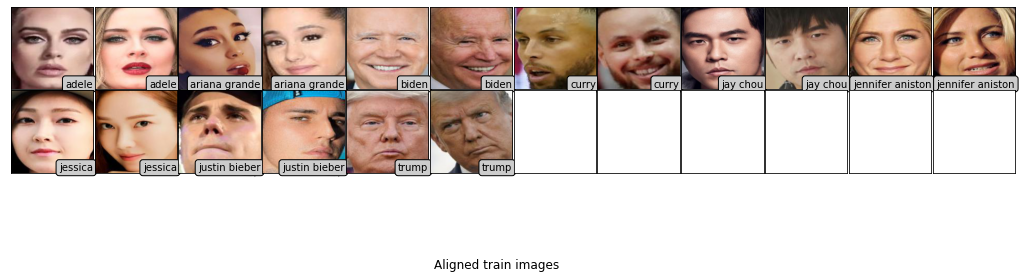

In [25]:
trainF = get_files(ALIGNED_TRAIN_DIR)
plot(paths=trainF, title='Aligned train images')

In [26]:
def fixed_denormalize(image): 
    """ Restandartize images to [0, 255]"""
    return image * 128 + 127.5

def getEmbeds(model, n, loader, imshow=False, n_img=5):
    model.eval()
    # images to display 
    images = []

    embeds, labels = [], []
    for n_i in tqdm.trange(n): 
        for i, (x, y) in enumerate(loader, 1): 

            # on each first batch get 'n_img' images  
            if imshow and i == 1: 
                inds = np.random.choice(x.size(0), min(x.size(0), n_img))
                images.append(fixed_denormalize(x[inds].data.cpu()).permute((0, 2, 3, 1)).numpy())

            embed = model(x.to(device))
            embed = embed.cpu().detach().numpy()
            print(embed.shape)
            embeds.append(embed), labels.extend(y.data.cpu().numpy())

    if imshow: 
        plot(images=np.concatenate(images))

    return np.concatenate(embeds), np.array(labels)

In [27]:
# model.eval()
# # images to display 
# images = []
# loader = trainL
# n_img=1
# embeds, labels = [], []
# for n_i in tqdm.trange(1): 
#     for i, (x, y) in enumerate(loader, 1): 

#         # on each first batch get 'n_img' images  
#         if imshow and i == 1: 
#             inds = np.random.choice(x.size(0), min(x.size(0), n_img))
#             images.append(fixed_denormalize(x[inds].data.cpu()).permute((0, 2, 3, 1)).numpy())

#         embed = model(x.to(device))
#         print(embed.shape)

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


(18, 512)


  2%|▏         | 1/50 [00:00<00:24,  2.03it/s]

(18, 512)


  4%|▍         | 2/50 [00:01<00:24,  1.99it/s]

(18, 512)


  6%|▌         | 3/50 [00:01<00:22,  2.08it/s]

(18, 512)


  8%|▊         | 4/50 [00:01<00:21,  2.17it/s]

(18, 512)


 10%|█         | 5/50 [00:02<00:20,  2.25it/s]

(18, 512)


 12%|█▏        | 6/50 [00:02<00:20,  2.15it/s]

(18, 512)


 14%|█▍        | 7/50 [00:03<00:19,  2.20it/s]

(18, 512)


 16%|█▌        | 8/50 [00:03<00:19,  2.20it/s]

(18, 512)


 18%|█▊        | 9/50 [00:04<00:18,  2.16it/s]

(18, 512)


 20%|██        | 10/50 [00:04<00:18,  2.18it/s]

(18, 512)


 22%|██▏       | 11/50 [00:05<00:17,  2.19it/s]

(18, 512)


 24%|██▍       | 12/50 [00:05<00:17,  2.18it/s]

(18, 512)


 26%|██▌       | 13/50 [00:06<00:17,  2.15it/s]

(18, 512)


 28%|██▊       | 14/50 [00:06<00:16,  2.14it/s]

(18, 512)


 30%|███       | 15/50 [00:06<00:16,  2.17it/s]

(18, 512)


 32%|███▏      | 16/50 [00:07<00:15,  2.21it/s]

(18, 512)


 34%|███▍      | 17/50 [00:07<00:14,  2.24it/s]

(18, 512)


 36%|███▌      | 18/50 [00:08<00:14,  2.21it/s]

(18, 512)


 38%|███▊      | 19/50 [00:08<00:14,  2.19it/s]

(18, 512)


 40%|████      | 20/50 [00:09<00:14,  2.09it/s]

(18, 512)


 42%|████▏     | 21/50 [00:09<00:13,  2.11it/s]

(18, 512)


 44%|████▍     | 22/50 [00:10<00:13,  2.15it/s]

(18, 512)


 46%|████▌     | 23/50 [00:10<00:12,  2.13it/s]

(18, 512)


 48%|████▊     | 24/50 [00:11<00:12,  2.13it/s]

(18, 512)


 50%|█████     | 25/50 [00:11<00:11,  2.17it/s]

(18, 512)


 52%|█████▏    | 26/50 [00:12<00:10,  2.18it/s]

(18, 512)


 54%|█████▍    | 27/50 [00:12<00:10,  2.19it/s]

(18, 512)


 56%|█████▌    | 28/50 [00:12<00:09,  2.26it/s]

(18, 512)


 58%|█████▊    | 29/50 [00:13<00:09,  2.28it/s]

(18, 512)


 60%|██████    | 30/50 [00:13<00:08,  2.26it/s]

(18, 512)


 62%|██████▏   | 31/50 [00:14<00:08,  2.26it/s]

(18, 512)


 64%|██████▍   | 32/50 [00:14<00:08,  2.24it/s]

(18, 512)


 66%|██████▌   | 33/50 [00:15<00:07,  2.27it/s]

(18, 512)


 68%|██████▊   | 34/50 [00:15<00:06,  2.30it/s]

(18, 512)


 70%|███████   | 35/50 [00:15<00:06,  2.30it/s]

(18, 512)


 72%|███████▏  | 36/50 [00:16<00:06,  2.29it/s]

(18, 512)


 74%|███████▍  | 37/50 [00:16<00:05,  2.26it/s]

(18, 512)


 76%|███████▌  | 38/50 [00:17<00:05,  2.24it/s]

(18, 512)


 78%|███████▊  | 39/50 [00:17<00:04,  2.24it/s]

(18, 512)


 80%|████████  | 40/50 [00:18<00:04,  2.22it/s]

(18, 512)


 82%|████████▏ | 41/50 [00:18<00:04,  2.22it/s]

(18, 512)


 84%|████████▍ | 42/50 [00:19<00:03,  2.22it/s]

(18, 512)


 86%|████████▌ | 43/50 [00:19<00:03,  2.21it/s]

(18, 512)


 88%|████████▊ | 44/50 [00:20<00:02,  2.12it/s]

(18, 512)


 90%|█████████ | 45/50 [00:20<00:02,  2.09it/s]

(18, 512)


 92%|█████████▏| 46/50 [00:21<00:01,  2.14it/s]

(18, 512)


 94%|█████████▍| 47/50 [00:21<00:01,  2.21it/s]

(18, 512)


 96%|█████████▌| 48/50 [00:21<00:00,  2.23it/s]

(18, 512)


 98%|█████████▊| 49/50 [00:22<00:00,  2.21it/s]

(18, 512)


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]

(18, 512)


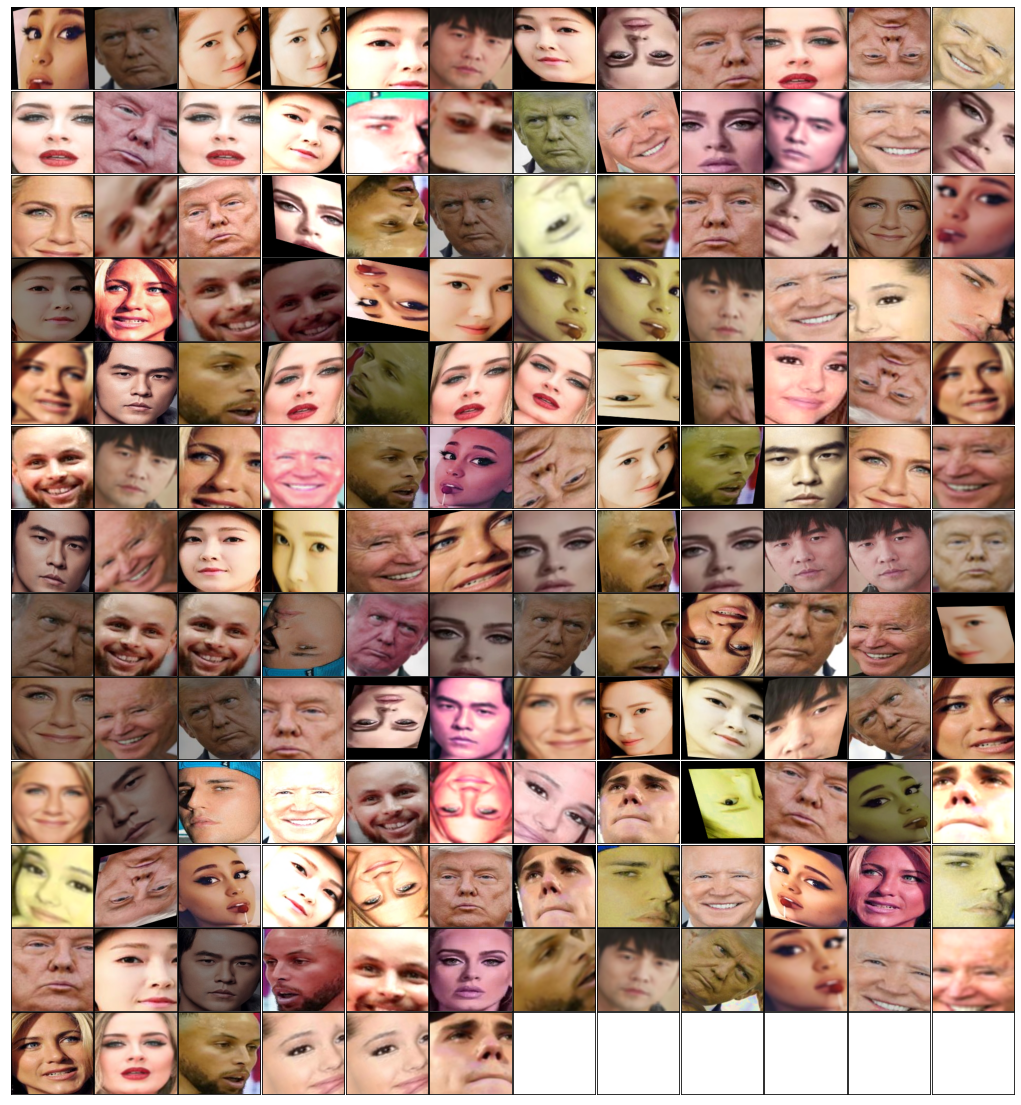

100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

(9, 512)


In [28]:
# 3. Get embeddings 
# Train embeddings 
trainEmbeds, trainLabels = getEmbeds(model, 1, trainL, False)
trainEmbeds_aug, trainLabels_aug = getEmbeds(model, 50, trainL_aug, imshow=True, n_img=3)

trainEmbeds = np.concatenate([trainEmbeds, trainEmbeds_aug])
trainLabels = np.concatenate([trainLabels, trainLabels_aug])

# Test embeddings 
testEmbeds, testLabels = getEmbeds(model, 1, testL, False)

In [29]:
from brevitas.export import FINNManager

FINNManager.export(model.to('cpu'), input_shape=(1, 3, 160, 160), export_path="facenet.onnx")

RuntimeError: ignored

In [30]:
# 4. Save embeddings 
TRAIN_EMBEDS = os.path.join(DATA_PATH, 'trainEmbeds.npz')
TEST_EMBEDS = os.path.join(DATA_PATH, 'testEmbeds.npz')

np.savez(TRAIN_EMBEDS, x=trainEmbeds, y=trainLabels)
np.savez(TEST_EMBEDS, x=testEmbeds, y=testLabels)

# Load the saved embeddings to use them futher 
trainEmbeds, trainLabels = np.load(TRAIN_EMBEDS, allow_pickle=True).values()
testEmbeds, testLabels = np.load(TEST_EMBEDS, allow_pickle=True).values()

# Get named labels
trainLabels, testLabels = IDX_TO_CLASS[trainLabels], IDX_TO_CLASS[testLabels]

In [31]:
from sklearn.metrics import pairwise_distances
import pandas as pd
import seaborn as sns 
sns.set()

def getDist(x, metric='euclidean', index=None, columns=None):
    dists = pairwise_distances(x, x, metric=metric)
    return pd.DataFrame(dists, index=index, columns=columns)

def heatmap(x, title='', cmap='Greens', linewidth=1):
    plt.figure(figsize=(17, 12))
    plt.title(title)
    sns.heatmap(x, cmap=cmap, square=True)
    plt.show()

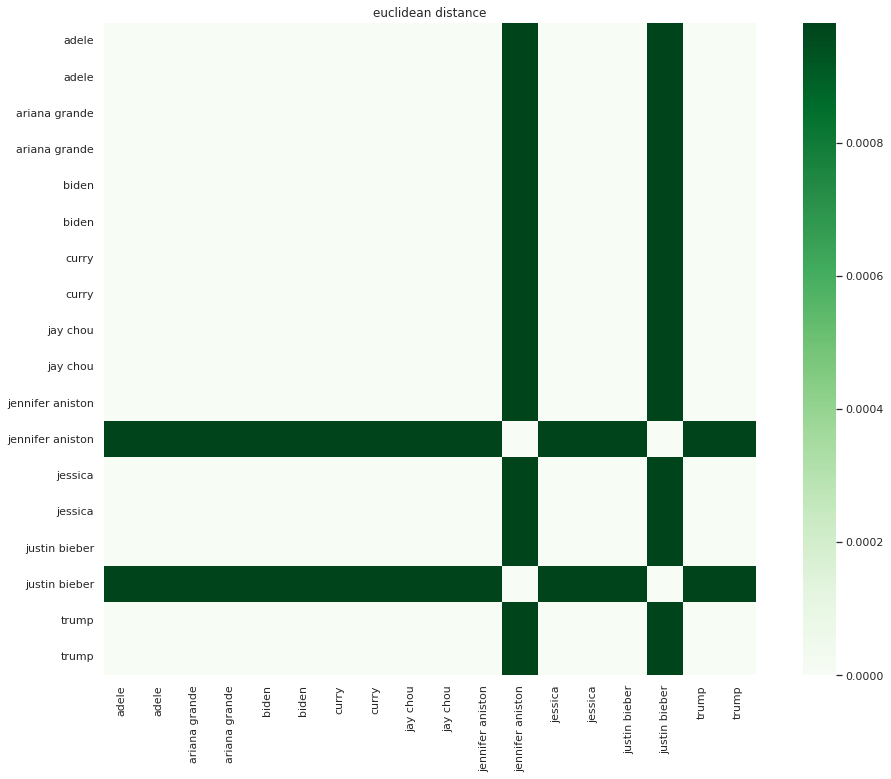

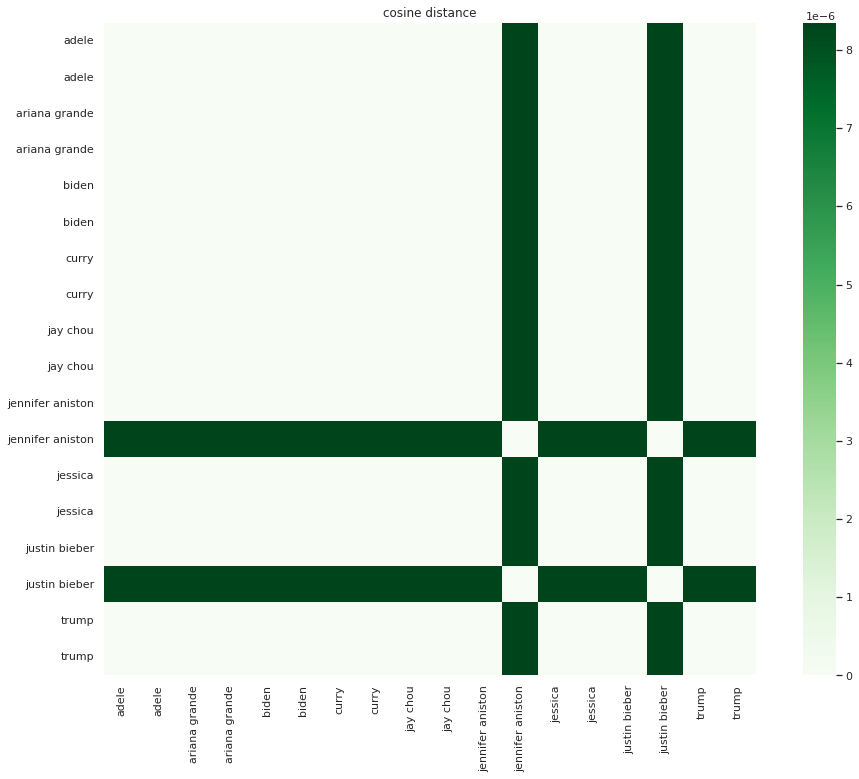

In [32]:
# Note 88 first images are original and 4247 are augmented
# as long as to calculate (4335, 512) distance matrix is time consuming we get only distances of originals 
inds = range(18)

# Train embeddings 
dists = getDist(trainEmbeds[inds], metric='euclidean', index=trainLabels[inds], columns=trainLabels[inds])
heatmap(dists, 'euclidean distance')

dists = getDist(trainEmbeds[inds], metric='cosine', index=trainLabels[inds], columns=trainLabels[inds])
heatmap(dists, 'cosine distance')

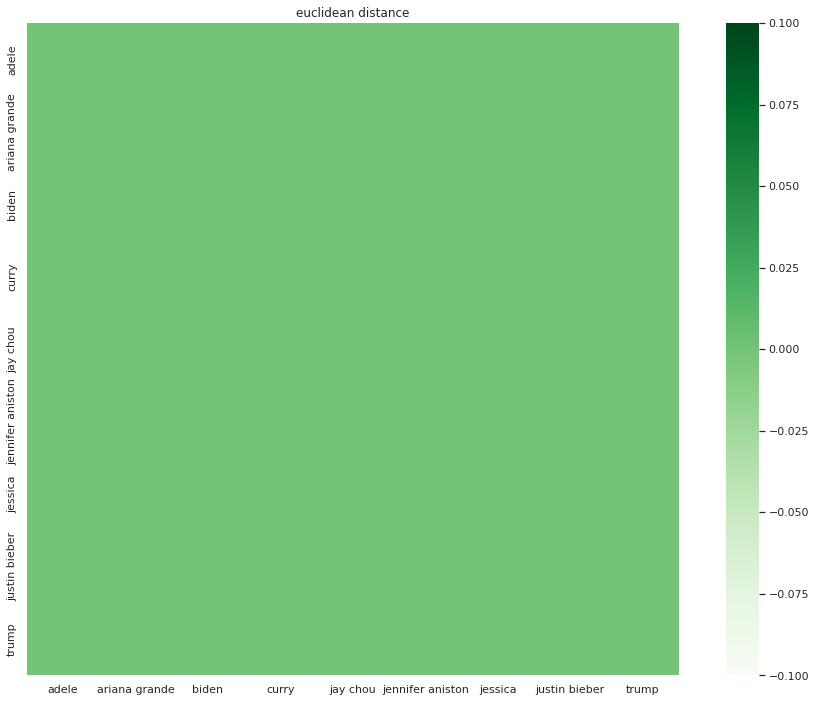

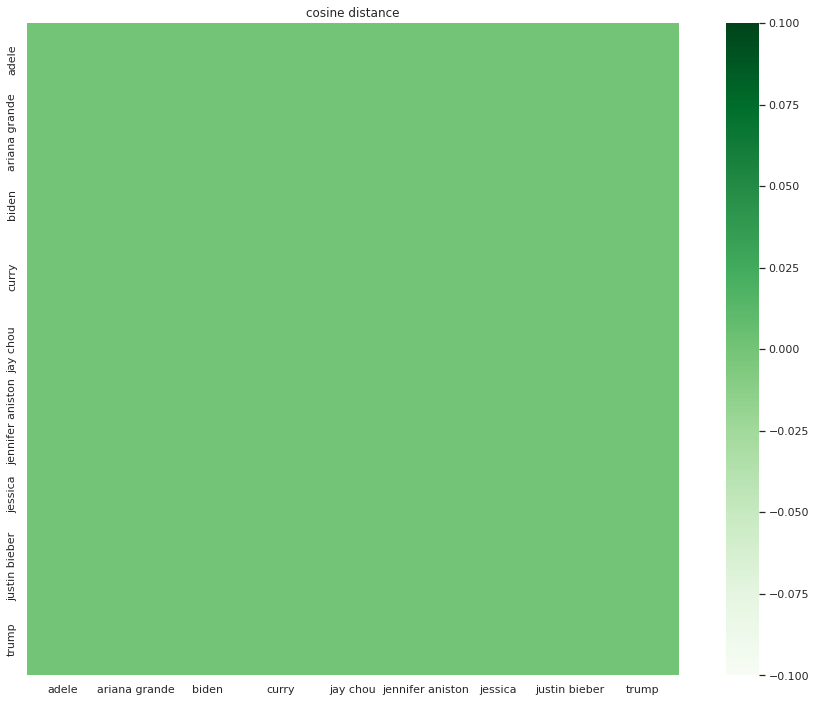

In [33]:
# Test embeddings 
dists = getDist(testEmbeds, metric='euclidean', index=testLabels, columns=testLabels)
heatmap(dists, 'euclidean distance')

dists = getDist(testEmbeds, metric='cosine', index=testLabels, columns=testLabels)
heatmap(dists, 'cosine distance')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


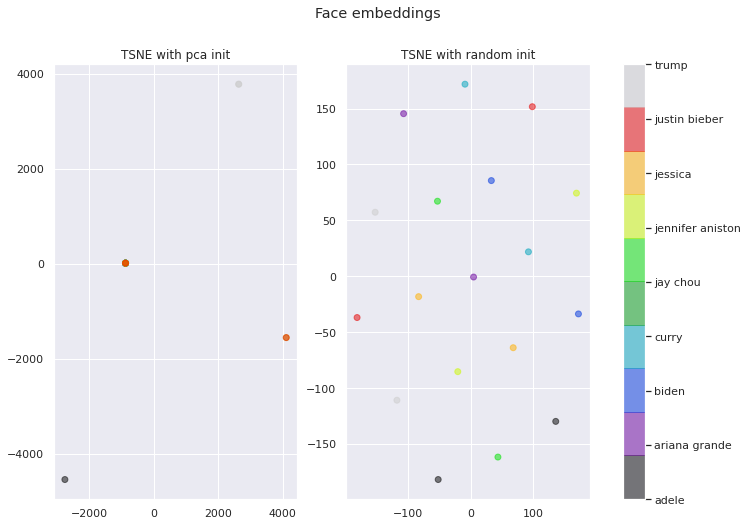

In [34]:
from sklearn.manifold import TSNE


inds = range(18)
X_tsne1 = TSNE(n_components=2, init='pca', random_state=33).fit_transform(trainEmbeds[inds])
X_tsne2 = TSNE(n_components=2, init='random', random_state=33).fit_transform(trainEmbeds[inds])
y = [CLASS_TO_IDX[label] for label in trainLabels[inds]]

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

img = ax[0].scatter(X_tsne1[:, 0], X_tsne1[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))
ax[1].scatter(X_tsne2[:, 0], X_tsne2[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))

ax[0].set_title('TSNE with pca init')
ax[1].set_title('TSNE with random init')
plt.suptitle('Face embeddings')

cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_yticklabels(np.unique(trainLabels[inds])) 
plt.show()

<class 'range'>


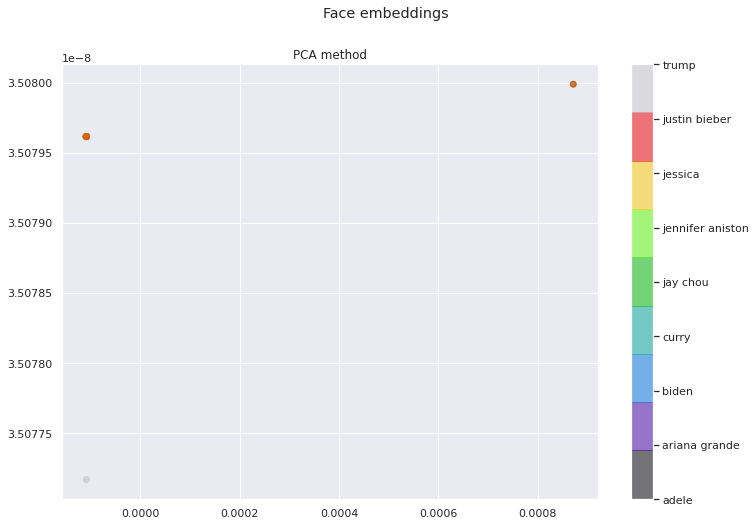

In [35]:
from sklearn.decomposition import PCA


inds = range(18)
print(type(inds))
X_pca1 = PCA(n_components=2, random_state=33).fit_transform(trainEmbeds[inds])
y = [CLASS_TO_IDX[label] for label in trainLabels[inds]]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
img = ax.scatter(X_pca1[:, 0], X_pca1[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 9))

plt.title('PCA method')
plt.suptitle('Face embeddings')

cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_yticklabels(np.unique(trainLabels[inds])) 
plt.show()

In [36]:
# data preparation 
X = np.copy(trainEmbeds)
y = np.array([CLASS_TO_IDX[label] for label in trainLabels])

print(f'X train embeds size: {X.shape}')
print(f'Tagret train size: {y.shape}')

X train embeds size: (918, 512)
Tagret train size: (918,)


In [37]:
%%time 

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings

warnings.filterwarnings('ignore', 'Solver terminated early.*')

param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 'auto'],
              'kernel': ['rbf', 'sigmoid', 'poly']}
model_params = {'class_weight': 'balanced', 'max_iter': 10, 'probability': True, 'random_state': 3}
model_svc = SVC(**model_params)
clf = GridSearchCV(model_svc, param_grid)
clf.fit(X, y)

print('Best estimator: ', clf.best_estimator_)
print('Best params: ', clf.best_params_)

Best estimator:  SVC(C=10, class_weight='balanced', gamma='auto', kernel='poly', max_iter=10,
    probability=True, random_state=3)
Best params:  {'C': 10, 'gamma': 'auto', 'kernel': 'poly'}
CPU times: user 1min 48s, sys: 807 ms, total: 1min 49s
Wall time: 1min 52s


In [38]:
import joblib

SVM_PATH = os.path.join(DATA_PATH, 'svm.sav')
joblib.dump(clf, SVM_PATH)
clf = joblib.load(SVM_PATH)

In [39]:
# test data preparation 
X_test, y_test = np.copy(testEmbeds), np.array([CLASS_TO_IDX[label] for label in testLabels])
print(f'X train embeds size: {X_test.shape}')
print(f'Tagret train size: {y_test.shape}')

X train embeds size: (9, 512)
Tagret train size: (9,)


In [40]:
from sklearn.metrics import accuracy_score

inds = range(18)
train_acc = accuracy_score(clf.predict(X[inds]), y[inds])
print(f'Accuracy score on train data: {train_acc:.3f}')

test_acc = accuracy_score(clf.predict(X_test), y_test)
print(f'Accuracy score on test data: {test_acc}')

Accuracy score on train data: 0.167
Accuracy score on test data: 0.1111111111111111
